Код для выполнения тестового задания на должность исследователя-аналитика.
Выполнил: Олег Адамович


# Скачать данные об объеме социальных выплат и налогооблагаемых денежных доходов в разрезе муниципальных образований и версионный справочник муниципальных образований от СберИндекс.

In [1]:
import pandas as pd
import geopandas as gpd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
from scipy import stats



C:\Users\User\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Убираем ограничение на количество выводимых строк
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Сначала таблицу эксель надо привести в машиночитаемый вид

In [3]:
# Путь к файлу
file_path = "Urov-14a_2010-2022.xlsx"

# Создаем пустой список для хранения итоговых данных
final_data = []

# Список для значений, не соответствующих условиям
unmatched_oktmo = []

# Функция для обработки каждого листа
def process_sheet(sheet_name, year):
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=4)
    
    # Переменные для хранения текущего региона и типа административного деления
    region = None
    region_code = None
    
    # Проходим по строкам
    for index, row in df.iterrows():
        oktmo = row['Код ОКТМО']
        
        if pd.isna(oktmo):
            continue
        
        # Преобразуем код ОКТМО в строку, удаляем пробелы и ведущие нули
        oktmo_str = str(oktmo).replace(' ', '').replace('\xa0', '').lstrip('0')
        #убираем опечатки в датасете
        # Проверка и изменение кода ОКТМО в начале
        if oktmo_str == '24626000':
            oktmo_str = '34626000'
        elif oktmo_str == '17725000' and region_code == 14:
            oktmo_str = '14725000'
        # Вручную добавляем Магаданской области код, потому что в файле его нет.
        # Проверка на начало ОКТМО с "44" для Магаданской области
        if oktmo_str.startswith('44'):
            region = 'Магаданская область'
            region_code = 44
        
        # Пропускаем строки, если код заканчивается на '00000'
        # На 00000 заканчивается не конкретный муниципалитет, а тип административных единиц.
        if oktmo_str.endswith('00000'):
            continue

        # Проверка специальных условий для Архангельской области с НАО
        if oktmo_str == '11811000' or oktmo_str == '11851000':
            region = 'Архангельская область с НАО'
        elif len(oktmo_str) == 1 or len(oktmo_str) == 2:
            # Определяем регион, если код состоит из 1-2 цифр
            region = row['Unnamed: 1']
            region_code = int(oktmo_str)
            continue
        #прописываем условия, как по разному точно определить административный тип муниципалитета.
        # Определяем административный тип по правилам
        sixth_digit = oktmo_str[-6]
        fifth_digit = int(oktmo_str[-5])

        if sixth_digit == '4':
            admin_type = 'Городской округ'
        elif sixth_digit == '2' and region_code == 7:
            admin_type = 'Муниципальный район'
        elif sixth_digit == '2' and region_code == 40:
            admin_type = 'Административный район'
        elif sixth_digit == '6':
            admin_type = 'Муниципальный район'
        elif sixth_digit == '5':
            admin_type = 'Муниципальный округ'
        elif sixth_digit == '7':
            admin_type = 'Городской округ'
        elif sixth_digit == '2':
            admin_type = 'Городской округ'
        elif sixth_digit == '1':
            admin_type = 'Городской округ'
        elif sixth_digit == '3':
            admin_type = 'Административный район'
        elif sixth_digit == '8' and 0 < fifth_digit < 5:
            admin_type = 'Муниципальный район'
        elif sixth_digit == '8' and fifth_digit >= 5:
            admin_type = 'Городской округ'
        elif sixth_digit == '9' and 0 < fifth_digit < 5:
            admin_type = 'Муниципальный район'
        elif sixth_digit == '9' and fifth_digit >= 5:
            admin_type = 'Городской округ'
        else:
            unmatched_oktmo.append(oktmo_str)
            continue  # Пропускаем строку, если условия не выполнены

        # Преобразуем Код ОКТМО в формат int и добавляем запись в итоговый список
        try:
            final_data.append({
                'Регион': region,
                'Номер региона': region_code,
                'Административный тип': admin_type,
                'Название': row['Unnamed: 1'],
                'Код ОКТМО': int(oktmo_str),  # Сохраняем в формате int
                'Год': year,
                'Доходы физлиц и ИП, т.р.': row['Налогооблагаемые денежные доходы физических лиц и индивидуальных предпринимателей, тыс.рублей'],
                'Соц. выплаты, т.р.': row['Социальные и другие выплаты, тыс.рублей'],
                'Общие выплаты и доходы, т.р.': row['Объем социальных выплат населению и налогооблагаемых денежных доходов населения, тыс.рублей'],
                'Выплаты и доходы на 1 жителя, р.': row['Объем социальных выплат и налогооблагаемых денежных доходов населения в среднем на 1 жителя муниципального района (городского округа), рублей']
            })
        except ValueError as e:
            print(f"Ошибка при преобразовании Код ОКТМО: {oktmo_str}. Ошибка: {e}")
            unmatched_oktmo.append(oktmo_str)

# Обрабатываем данные для периода с 2018 по 2022 год
for year in range(2018, 2023):
    process_sheet(str(year), year)

# Превращаем данные в DataFrame
final_df = pd.DataFrame(final_data)

# Преобразуем тип данных для столбца 'Номер региона' в числовой формат (int)
final_df['Номер региона'] = final_df['Номер региона'].astype(int)

# Сортируем данные по 'Номер региона', 'Год', 'Административный тип' и 'Код ОКТМО'
final_df = final_df.sort_values(by=['Номер региона', 'Год', 'Административный тип', 'Код ОКТМО'], ascending=[True, True, True, True]).reset_index(drop=True)

# Просмотр итоговых данных
print(final_df.head())

# Список значений, которые не соответствовали условиям
print("Не соответствующие условиям коды ОКТМО:", unmatched_oktmo)


           Регион  Номер региона Административный тип       Название  \
0  Алтайский край              1      Городской округ     г. Барнаул   
1  Алтайский край              1      Городской округ      г. Алейск   
2  Алтайский край              1      Городской округ  г. Белокуриха   
3  Алтайский край              1      Городской округ       г. Бийск   
4  Алтайский край              1      Городской округ     г. Заринск   

   Код ОКТМО   Год  Доходы физлиц и ИП, т.р.  Соц. выплаты, т.р.  \
0    1701000  2018              1.433911e+08        4.892531e+07   
1    1703000  2018              2.350672e+06        1.958745e+06   
2    1704000  2018              3.358961e+06        1.104414e+06   
3    1705000  2018              2.864631e+07        1.667412e+07   
4    1706000  2018              6.135012e+06        3.363121e+06   

   Общие выплаты и доходы, т.р.  Выплаты и доходы на 1 жителя, р.  
0                  1.923164e+08                     276095.782098  
1                  4.3

In [4]:
final_df.sample(30)

Регион  Номер региона Административный тип  \
7163                Саратовская область               63  Муниципальный район   
9725                 Республика Дагестан              82  Муниципальный район   
3545                    Калужская область             29  Муниципальный район   
10307                    Республика Коми              87      Городской округ   
2837                   Ивановская область             24  Муниципальный район   
1637                Белгородская область              14      Городской округ   
4534                   Курганская область             37  Муниципальный район   
7940                  Тамбовская область              68  Муниципальный район   
5947                Оренбургская область              53  Муниципальный район   
8171                    Тульская область              70      Городской округ   
9449             Республика Башкортостан              80  Муниципальный район   
2562                Нижегородская область             22      Городской округ   
142                        Алтайский край              1      Городской округ   
3404                    Тверская область              28  Муниципальный район   
3337                    Тверская область              28      Городской округ   
7357                  Сахалинская область             64      Городской округ   
6149                   Орловская  область             54  Муниципальный район   
4362                    Самарская область             36      Городской округ   
2006               Волгоградская область              18  Муниципальный район   
7133                    Рязанская область             61  Муниципальный район   
5840                      Омская область              52  Муниципальный район   
8979                   Забайкальский край             76  Муниципальный район   
5185                  Московская область              46      Городской округ   
3347                    Тверская область              28  Муниципальный округ   
7853                  Смоленская область              66  Муниципальный район   
3622                     Камчатский край              30  Муниципальный район   
2770                   Ивановская область             24      Городской округ   
6831                  Ростовская область              60  Муниципальный район   
8492   Ханты-Мансийский автономный округ              71      Городской округ   
1090                 Ставропольский край               7  Муниципальный округ   

             Название  Код ОКТМО   Год  Доходы физлиц и ИП, т.р.  \
7163   Екатериновский   63616000  2018              3.075907e+06   
9725    Казбековский    82622000  2018              2.970943e+06   
3545     Куйбышевский   29618000  2021              5.879134e+05   
10307       г. Вуктыл   87712000  2022              5.745912e+06   
2837       Палехский    24617000  2022              1.365403e+06   
1637       Валуйский    14720000  2020              9.110443e+06   
4534       Мишкинский   37622000  2020              1.331021e+06   
7940    Никифоровский   68620000  2018              2.011374e+06   
5947      Асекеевский   53607000  2019              2.432809e+06   
8171       г. Донской   70706000  2018              4.668910e+06   
9449    Нуримановский   80645000  2020              1.836664e+06   
2562       г. Арзамас   22703000  2020              2.234240e+07   
142       г. Рубцовск    1716000  2020              1.363691e+07   
3404      Калининский   28620000  2021              1.577602e+07   
3337         г. Тверь   28701000  2020              1.240100e+08   
7357     Корсаковский   64716000  2018              8.405246e+06   
6149     Шаблыкинский   54659000  2019              5.784187e+05   
4362     г. Октябрьск   36718000  2020              2.222108e+06   
2006      Даниловский   18606000  2019              1.695664e+06   
7133     Михайловский   61617000  2022              4.203144e+06   
5840    Называевский    52636000  2021              1.882043e+06   
8979   Могойтуйский     766

In [5]:
# Подсчет количества значений с пятью нулями в конце
count_five_zeros = final_df['Код ОКТМО'].astype(str).str.endswith('00000').sum()

print(f"Количество значений с пятью нулями: {count_five_zeros}")

Количество значений с пятью нулями: 0


In [6]:
#проверим. есть ли дубликаты
final_df.duplicated().sum()

42

In [7]:
#посмотрим на них
duplicates = final_df[final_df.duplicated(keep=False)]
duplicates

Регион  Номер региона Административный тип  \
3016  Иркутская область             25      Городской округ   
3017  Иркутская область             25      Городской округ   
3018  Иркутская область             25      Городской округ   
3019  Иркутская область             25      Городской округ   
3020  Иркутская область             25      Городской округ   
3021  Иркутская область             25      Городской округ   
3022  Иркутская область             25      Городской округ   
3023  Иркутская область             25      Городской округ   
3024  Иркутская область             25      Городской округ   
3025  Иркутская область             25      Городской округ   
3026  Иркутская область             25      Городской округ   
3027  Иркутская область             25      Городской округ   
3028  Иркутская область             25      Городской округ   
3029  Иркутская область             25      Городской округ   
3030  Иркутская область             25      Городской округ   
3031  Иркутская область             25      Городской округ   
3032  Иркутская область             25      Городской округ   
3033  Иркутская область             25      Городской округ   
3034  Иркутская область             25      Городской округ   
3035  Иркутская область             25      Городской округ   
3036  Иркутская область             25  Муниципальный район   
3037  Иркутская область             25  Муниципальный район   
3038  Иркутская область             25  Муниципальный район   
3039  Иркутская область             25  Муниципальный район   
3040  Иркутская область             25  Муниципальный район   
3041  Иркутская область             25  Муниципальный район   
3042  Иркутская область             25  Муниципальный район   
3043  Иркутская область             25  Муниципальный район   
3044  Иркутская область             25  Муниципальный район   
3045  Иркутская область             25  Муниципальный район   
3046  Иркутская область             25  Муниципальный район   
3047  Иркутская область             25  Муниципальный район   
3048  Иркутская область             25  Муниципальный район   
3049  Иркутская область             25  Муниципальный район   
3050  Иркутская область             25  Муниципальный район   
3051  Иркутская область             25  Муниципальный район   
3052  Иркутская область             25  Муниципальный район   
3053  Иркутская область             25  Муниципальный район   
3054  Иркутская область             25  Муниципальный район   
3055  Иркутская область             25  Муниципальный район   
3056  Иркутская область             25  Муниципальный район   
3057  Иркутская область             25  Муниципальный район   
3058  Иркутская область             25  Муниципальный район   
3059  Иркутская область             25  Муниципальный район   
3060  Иркутская область             25  Муниципальный район   
3061  Иркутская область             25  Муниципальный район   
3062  Иркутская область             25  Муниципальный район   
3063  Иркутская область             25  Муниципальный район   
3064  Иркутская область             25  Муниципальный район   
3065  Иркутская область             25  Муниципальный район   
3066  Иркутская область             25  Муниципальный район   
3067  Иркутская область             25  Муниципальный район   
3068  Иркутская область             25  Муниципальный район   
3069  Иркутская область             25  Муниципальный район   
3070  Иркутская область             25  Муниципальный район   
3071  Иркутская область             25  Муниципальный район   
3072  Иркутская область             25  Муниципальный район   
3073  Иркутская область             25  Муниципальный район   
3074  Иркутская область             25  Муниципальный район   
3075  Иркутская область             25  Муниципальный район   
3076  Иркутская область             25  Муниципальный район   
3077  Иркутская область             25  Муниципальный район   
3078  Иркутская область             25  Муниципа

In [8]:
#удалим дубликаты
final_df = final_df.drop_duplicates(keep=False)
final_df.duplicated().sum()

0

In [9]:
# Функция для проверки соответствия кода ОКТМО номеру региона
def check_region_code(row):
    region = str(row['Номер региона'])
    oktmo_code = str(row['Код ОКТМО']).zfill(8)  # Добавляем ведущие нули до 8 цифр

    # Проверяем, соответствует ли Номер региона седьмой или седьмой и восьмой цифрам кода ОКТМО
    return region == oktmo_code[-7:-6] or region == oktmo_code[-8:-6]

# Применяем функцию к каждому ряду и считаем долю соответствий
match_ratio = final_df.apply(check_region_code, axis=1).mean()
match_ratio

1.0

Все код ОКТМО соответствуют своим регионам

In [10]:
# Заменяем 'г.' на 'г. ' (с пробелом)
final_df['Название'] = final_df['Название'].str.replace(r'(?<=\.)(\w)', r' \1', regex=True)

In [11]:
# Сохранение итогового результата в файл, если нужно
#final_df.to_excel("panel_data_2018_2022_cleaned.xlsx", index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_19008\390332353.py:2: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  final_df.to_excel("panel_data_2018_2022_cleaned.xlsx", index=False)


In [12]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11506 entries, 0 to 11589
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Регион                            11506 non-null  object 
 1   Номер региона                     11506 non-null  int32  
 2   Административный тип              11506 non-null  object 
 3   Название                          11506 non-null  object 
 4   Код ОКТМО                         11506 non-null  int64  
 5   Год                               11506 non-null  int64  
 6   Доходы физлиц и ИП, т.р.          11506 non-null  float64
 7   Соц. выплаты, т.р.                11506 non-null  float64
 8   Общие выплаты и доходы, т.р.      11506 non-null  float64
 9   Выплаты и доходы на 1 жителя, р.  11506 non-null  float64
dtypes: float64(4), int32(1), int64(2), object(3)
memory usage: 943.9+ KB


In [13]:
#проверим единообразие написания регионов
final_df['Регион'].unique()

array(['Алтайский край', 'Краснодарский край     ', 'Красноярский край',
       'Приморский край ', 'Ставропольский край ', 'Хабаровский край ',
       'Амурская область', 'Архангельская область без НАО',
       'Архангельская область с НАО', 'Астраханская область',
       'Белгородская область ', 'Брянская область ',
       'Владимирская область', 'Волгоградская область ',
       'Вологодская область', 'Воронежская область ',
       'Нижегородская область', 'Ивановская область', 'Иркутская область',
       'Республика Ингушетия', 'Калининградская область',
       'Калининградская область- всего', 'Тверская область ',
       'Калужская область', 'Камчатский край ',
       'Кемеровская область          ',
       'Кемеровская область - Кузбасс          ', 'Кировская область ',
       'Костромская область ', 'Республика Крым', 'Самарская область',
       'Курганская область', 'Курская область ', 'г. Санкт-Петербург',
       'Ленинградская область', 'Липецкая область ',
       'Магаданская

In [14]:
# Удаление пробелов перед первой и последней буквой
final_df['Регион'] = final_df['Регион'].str.strip()

In [15]:
final_df['Регион'].unique()

array(['Алтайский край', 'Краснодарский край', 'Красноярский край',
       'Приморский край', 'Ставропольский край', 'Хабаровский край',
       'Амурская область', 'Архангельская область без НАО',
       'Архангельская область с НАО', 'Астраханская область',
       'Белгородская область', 'Брянская область', 'Владимирская область',
       'Волгоградская область', 'Вологодская область',
       'Воронежская область', 'Нижегородская область',
       'Ивановская область', 'Иркутская область', 'Республика Ингушетия',
       'Калининградская область', 'Калининградская область- всего',
       'Тверская область', 'Калужская область', 'Камчатский край',
       'Кемеровская область', 'Кемеровская область - Кузбасс',
       'Кировская область', 'Костромская область', 'Республика Крым',
       'Самарская область', 'Курганская область', 'Курская область',
       'г. Санкт-Петербург', 'Ленинградская область', 'Липецкая область',
       'Магаданская область', 'Московская область', 'Мурманская область

In [16]:
# Изменение конкретных значений в столбце 'Регион'
final_df['Регион'] = final_df['Регион'].replace({
    'Калининградская область- всего': 'Калининградская область',
    'Чукотский автономный округ - всего': 'Чукотский автономный округ',
    'Кемеровская область - Кузбасс': 'Кемеровская область'
})

In [17]:
final_df['Регион'].unique()

array(['Алтайский край', 'Краснодарский край', 'Красноярский край',
       'Приморский край', 'Ставропольский край', 'Хабаровский край',
       'Амурская область', 'Архангельская область без НАО',
       'Архангельская область с НАО', 'Астраханская область',
       'Белгородская область', 'Брянская область', 'Владимирская область',
       'Волгоградская область', 'Вологодская область',
       'Воронежская область', 'Нижегородская область',
       'Ивановская область', 'Иркутская область', 'Республика Ингушетия',
       'Калининградская область', 'Тверская область', 'Калужская область',
       'Камчатский край', 'Кемеровская область', 'Кировская область',
       'Костромская область', 'Республика Крым', 'Самарская область',
       'Курганская область', 'Курская область', 'г. Санкт-Петербург',
       'Ленинградская область', 'Липецкая область', 'Магаданская область',
       'Московская область', 'Мурманская область', 'Новгородская область',
       'Новосибирская область', 'Омская область

In [18]:
#Посмотрим количество муниципалитетов для одного года
len(final_df[final_df['Год'] == 2021])

2326

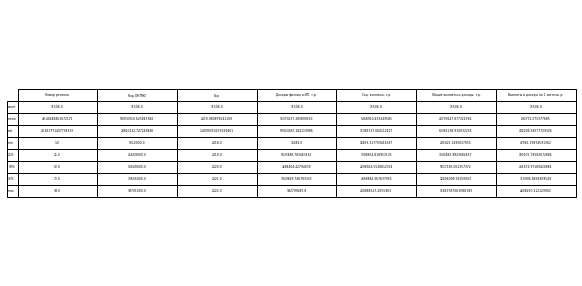

In [19]:
#Сохраим датасет в виде картинки дял отчета.
# Описание данных
# description = final_df.describe()

# # Настройка фигуры для таблицы
# fig, ax = plt.subplots(figsize=(10, 5))  # Установите нужный размер
# ax.axis('tight')
# ax.axis('off')
# table = ax.table(cellText=description.values,
#                  colLabels=description.columns,
#                  rowLabels=description.index,
#                  cellLoc='center',
#                  loc='center')

# # Сохранение в файл PNG
# plt.savefig("final_df_description.png", dpi=300, bbox_inches='tight')


## Теперь ознакомимся с версионным справочником

In [20]:
# Путь к файлу
file_path = "t_dict_municipal_districts.xlsx"

# Чтение файла Excel
t_dic = pd.read_excel(file_path)
t_dic.sample(5)

municipal_district_name_short           oktmo  \
2333                     Рыбинский  78-640-000-000   
1281                     Нагорский  33-625-000-000   
2565                   Теплый Стан  45-907-000-000   
1966                     Тымовский  64-750-000-000   
47                     Гафурийский  80-621-000-000   

                                municipal_district_name  \
2333                      Рыбинский муниципальный район   
1281                      Нагорский муниципальный район   
2565  внутригородская территория города федерального...   
1966                          городской округ Тымовский   
47                      Гафурийский муниципальный район   

                                municipal_district_type  \
2333                                муниципальный район   
1281                                муниципальный район   
2565  внутригородская территория города федерального...   
1966                                    городской округ   
47                                  муниципальный район   

     municipal_district_status  shape shape_linked_oktmo  \
2333                       NaN      3     78-715-000-000   
1281                       NaN      1                NaN   
2565                       NaN      1                NaN   
1966                       NaN      1                NaN   
47                         NaN      1                NaN   

     municipal_district_center                        source_rosstat  \
2333                 г Рыбинск  data-20180110-structure-20150128.csv   
1281               пгт Нагорск  data-20180110-structure-20150128.csv   
2565                       NaN  data-20180110-structure-20150128.csv   
1966             пгт Тымовское  data-20180110-structure-20150128.csv   
47           с Красноусольский  data-20180110-structure-20150128.csv   

      year_from  year_to  territory_id  region_code              region_name  \
2333       2018     9999          2334           76      Ярославская область   
1281       2018     9999          1282           43        Кировская область   
2565       2018     9999          2566           77                   Москва   
1966       2018     9999          1967           65      Сахалинская область   
47         2018     9999            48            2  Республика Башкортостан   

      municipal_district_center_lat  municipal_district_center_lon  
2333                      58.050373                      38.834637  
1281                      59.315914                      50.801731  
2565                            NaN                            NaN  
1966                      50.845556                     142.655000  
47                        53.896162                      56.470560

In [21]:
t_dic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3101 entries, 0 to 3100
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   municipal_district_name_short  3101 non-null   object 
 1   oktmo                          3101 non-null   object 
 2   municipal_district_name        3101 non-null   object 
 3   municipal_district_type        3101 non-null   object 
 4   municipal_district_status      42 non-null     object 
 5   shape                          3101 non-null   int64  
 6   shape_linked_oktmo             359 non-null    object 
 7   municipal_district_center      2839 non-null   object 
 8   source_rosstat                 3101 non-null   object 
 9   year_from                      3101 non-null   int64  
 10  year_to                        3101 non-null   int64  
 11  territory_id                   3101 non-null   int64  
 12  region_code                    3101 non-null   i

In [22]:
# Код ОКТМО приведем в тот же вид, что и в final_df
# Удаляем дефисы, обрезаем только последние три нуля, если они есть, и преобразуем в int
t_dic['oktmo'] = t_dic['oktmo'].str.replace('-', '').apply(lambda x: x[:-3] if x.endswith('000') else x).astype(int)

# Проверяем результат
print(t_dic['oktmo'].head())

0    79701000
1    79703000
2    79605000
3    79615000
4    79618000
Name: oktmo, dtype: int32


In [23]:
t_dic['year_from'].value_counts(normalize=True)

year_from
2018    0.843921
2023    0.042244
2021    0.032570
2024    0.028378
2022    0.021928
2020    0.020639
2019    0.010319
Name: proportion, dtype: float64

In [24]:
t_dic['year_to'].value_counts(normalize=True)

year_to
9999    0.836504
2023    0.044502
2021    0.034183
2024    0.029023
2022    0.021928
2020    0.021928
2019    0.011932
Name: proportion, dtype: float64

In [25]:
t_dic[t_dic['year_to'] != 9999]

municipal_district_name_short     oktmo  \
207                    Беломорский  86604000   
216                  Питкярантский  86633000   
220                      Сегежский  86645000   
222                     Суоярвский  86650000   
225                         Вуктыл  87712000   
227                         Усинск  87723000   
422                      Алнашский  94602000   
423                    Балезинский  94604000   
424                      Вавожский  94606000   
425                     Воткинский  94608000   
426                     Глазовский  94610000   
427                     Граховский  94612000   
428                      Дебёсский  94614000   
429                   Завьяловский  94616000   
430                      Игринский  94618000   
431                     Камбарский  94620000   
432                  Каракулинский  94622000   
433                        Кезский  94624000   
434                     Кизнерский  94626000   
435                     Киясовский  94628000   
436                  Красногорский  94630000   
437                 Малопургинский  94633000   
438                     Можгинский  94635000   
439                   Сарапульский  94637000   
440                     Селтинский  94639000   
441                     Сюмсинский  94641000   
442                       Увинский  94644000   
443                     Шарканский  94646000   
444                     Юкаменский  94648000   
445               Якшур-Бодьинский  94650000   
446                         Ярский  94652000   
472                     Сунженский  96631000   
482                     Алатырский  97603000   
483                     Аликовский  97605000   
484                    Батыревский  97607000   
485                     Вурнарский  97610000   
486                    Ибресинский  97613000   
487                      Канашский  97616000   
488                     Козловский  97619000   
489                  Комсомольский  97621000   
490                Красноармейский  97624000   
491                Красночетайский  97626000   
492            Мариинско-Посадский  97629000   
493                    Моргаушский  97632000   
494                       Порецкий  97635000   
495                      Урмарский  97638000   
496                     Цивильский  97641000   
497                   Чебоксарский  97644000   
498                   Шемуршинский  97647000   
499                   Шумерлинский  97650000   
500                      Ядринский  97653000   
501                     Яльчикский  97655000   
502                    Янтиковский  97658000   
510                      Славгород   1719000   
524                    Залесовский   1612000   
552                       Суетский   1641000   
569                      Чарышский   1658000   
579             Газимуро-Заводский  76610000   
581                      Каларский  76615000   
582                     Калганский  76618000   
587                    Могочинский  76626000   
591                       Ононский  76634000   
593                   Приаргунский  76638000   
609                      Алеутский  30601000   
612                    Мильковский  30610000   
627                           Сочи   3726000   
712                      Пировский   4645000   
720                     Тюхтетский   4655000   
723                    Шарыповский   4658000   
727                 Березниковский  57708000   
728                    Губахинский  57717000   
729                         Кунгур  57722000   
731                    Соликамский  57730000   
733                Александровский  57605000   
734                     Бардымский  57604000   
735                    Березовский  57606000   
736               Большесосновский  57608000   
737                  Верещагинский  57612000   
738                 Горнозаводский  57614000   
739                   Гремячинский  57615000   
740                     Добрянский  57616000   
741                       Еловский  57618000   
742                  

In [26]:
t_dic[t_dic['year_from'] != 2018]

municipal_district_name_short     oktmo  \
2617                     Мантурово  34714000   
2618          Переславль-Залесский  78705000   
2619                   Соликамский  57730000   
2620                     Березники  57708000   
2621                  Алексеевский  14710000   
2622                     Валуйский  14720000   
2623                 Грайворонский  14725000   
2624                Новооскольский  14735000   
2625                   Шебекинский  14750000   
2626                   Яковлевский  14755000   
2627                 Ликино-Дулёво  46749000   
2628                          Клин  46737000   
2629                   Дмитровский  46715000   
2630                    Талдомский  46778000   
2631                   Богородский  46751000   
2632                     Кашинский  28758000   
2633                   Нелидовский  28759000   
2634                    Балтийский  27705000   
2635                  Нестеровский  27715000   
2636                 Светлогорский  27734000   
2637                         Кизел  57719000   
2638                 Краснокамский  57720000   
2639                  Гремячинский  57715000   
2640                      Оханский  57729000   
2641                Горнозаводский  57714000   
2642                    Чайковский  57735000   
2643                      Серпухов  46770000   
2644                     Можайский  46745000   
2645                       Обнинск  29715000   
2646                     Боровский  29606000   
2647             Лосино-Петровский  46742000   
2648                    Щёлковский  46659000   
2649                Новозыбковский  15720000   
2650                   Одинцовский  46755000   
2651              Орехово-Зуевский  46757000   
2652                 Солнечногорск  46771000   
2653            Сергиево-Посадский  46728000   
2654                   Воскресенск  46710000   
2655                     Раменский  46768000   
2656                    Пушкинский  46758000   
2657                 Волоколамский  46708000   
2658                      Лотошино  46752000   
2659                  Весьегонский  28510000   
2660                Андреапольский  28502000   
2661               Красновишерский  57760000   
2662                 Верещагинский  57712000   
2663                      Осинский  57728000   
2664                  Чернушинский  57757000   
2665                    Суксунский  57731000   
2666                    Добрянский  57718000   
2667                     Ильинский  57759000   
2668                   Октябрьский  57761000   
2669                      Очерский  57762000   
2670                    Чердынский  57756000   
2671                     Чусовской  57758000   
2672                    Нытвенский  57727000   
2673               Александровский  57502000   
2674                   Березовский  57506000   
2675                     Ординский  57538000   
2676                      Гайнский  57513000   
2677                     Кочевский  57526000   
2678                  Кудымкарский  57528000   
2679                      Кудымкар  57721000   
2680                     Юрлинский  57559000   
2681                    Юсьвинский  57560000   
2682                       Уинский  57552000   
2683                     Косинский  57525000   
2684                   Богородский  33719000   
2685                    Санчурский  33716000   
2686                   Воротынский  22719000   
2687                Голышмановский  71702000   
2688                     Пировский   4545000   
2689                   Шарыповский   4558000   
2690                     Ижморский  32504000   
2691                   Кемеровский  32507000   
2692                  Крапивинский  32510000   
2693             Ленинск-Кузнецкий  32513000   
2694                 Прокопьевский  32522000   
2695              Промышленновский  32525000   
2696                    Топкинский  32531000   
2697                     Тяжинский  32534000   
2698                   Чебулинский  32537000   
2699                 

In [27]:
# Оставляем только нужные колонки
t_dic_filtered = t_dic[[
    "oktmo",
    "municipal_district_name",
    "year_from",
    "year_to",
    "territory_id",
    "region_name",
    "region_code"
]]

In [28]:
t_dic_filtered.head()

oktmo                municipal_district_name  year_from  year_to  \
0  79701000           городской округ город Майкоп       2018     9999   
1  79703000         городской округ город Адыгейск       2018     9999   
2  79605000         Гиагинский муниципальный район       2018     9999   
3  79615000      Кошехабльский муниципальный район       2018     9999   
4  79618000  Красногвардейский муниципальный район       2018     9999   

   territory_id        region_name  region_code  
0             1  Республика Адыгея            1  
1             2  Республика Адыгея            1  
2             3  Республика Адыгея            1  
3             4  Республика Адыгея            1  
4             5  Республика Адыгея            1

In [29]:
sorted(t_dic_filtered['region_code'].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 83,
 86,
 87,
 89,
 91,
 92]

In [30]:
t_dic_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3101 entries, 0 to 3100
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   oktmo                    3101 non-null   int32 
 1   municipal_district_name  3101 non-null   object
 2   year_from                3101 non-null   int64 
 3   year_to                  3101 non-null   int64 
 4   territory_id             3101 non-null   int64 
 5   region_name              3101 non-null   object
 6   region_code              3101 non-null   int64 
dtypes: int32(1), int64(4), object(2)
memory usage: 157.6+ KB


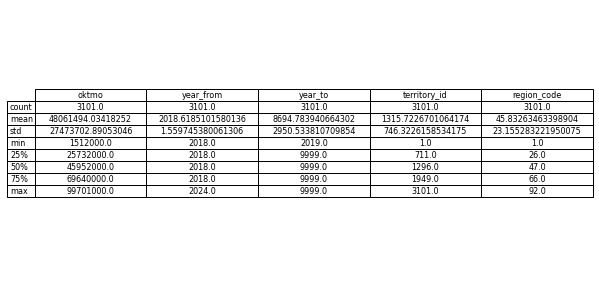

In [31]:
# # Создание DataFrame с описательной статистикой
# desc_stats = t_dic_filtered.describe()

# # Настройка фигуры для отображения таблицы
# fig, ax = plt.subplots(figsize=(10, 5))  # Задайте размер в зависимости от объема данных
# ax.axis('tight')
# ax.axis('off')

# # Создание таблицы
# table = ax.table(cellText=desc_stats.values,
#                  colLabels=desc_stats.columns,
#                  rowLabels=desc_stats.index,
#                  cellLoc='center',
#                  loc='center')

# # Сохранение таблицы как изображения
# plt.savefig("t_dic_filtered_describe.png", dpi=300, bbox_inches='tight')
# plt.show()

## Объединим датасеты

Датасеты объединяются на основании года и кода октмо. Строки из t_dic_filtered фильтруются по year_from и year_to и соединяются с только с соответствующими значениями из колонки "Год" в final_df. Так можно избежать дублирования, когда в t_dic_filtered может быть несколько наблюдения с одним октмо, но разными временными диапазонами в year_from и year_to.

In [32]:
# Функция для расширения каждой строки по годам в указанном диапазоне
def expand_row(row):
    years = list(range(row['year_from'], row['year_to'] + 1))
    expanded_rows = pd.DataFrame({
        'oktmo': row['oktmo'],
        'Year': years,
        'municipal_district_name': row['municipal_district_name'],
        'territory_id': row['territory_id'],
        'region_name': row['region_name'],
        'region_code': row['region_code']
    })
    return expanded_rows

# Расширяем t_dic_filtered по годам и включаем все столбцы
expanded_dic = pd.concat([expand_row(row) for _, row in t_dic_filtered.iterrows()], ignore_index=True)

# Объединение данных с учетом года
merged_df = final_df.merge(expanded_dic, left_on=['Код ОКТМО', 'Год'], right_on=['oktmo', 'Year'], how='left')

# Идентификация строк, которые не были объединены
t_dic_filtered_unmerged = t_dic_filtered[~t_dic_filtered['oktmo'].isin(merged_df['oktmo'].dropna())]

В t_dic_filtered_unmerged собраны строки, не присоединенные к merged_df

In [33]:
merged_df.head(10)

Регион  Номер региона Административный тип        Название  \
0  Алтайский край              1      Городской округ      г. Барнаул   
1  Алтайский край              1      Городской округ       г. Алейск   
2  Алтайский край              1      Городской округ   г. Белокуриха   
3  Алтайский край              1      Городской округ        г. Бийск   
4  Алтайский край              1      Городской округ      г. Заринск   
5  Алтайский край              1      Городской округ  г. Новоалтайск   
6  Алтайский край              1      Городской округ     г. Рубцовск   
7  Алтайский край              1      Городской округ    г. Славгород   
8  Алтайский край              1      Городской округ       г. Яровое   
9  Алтайский край              1  Муниципальный район        Алейский   

   Код ОКТМО   Год  Доходы физлиц и ИП, т.р.  Соц. выплаты, т.р.  \
0    1701000  2018              1.433911e+08        4.892531e+07   
1    1703000  2018              2.350672e+06        1.958745e+06   
2    1704000  2018              3.358961e+06        1.104414e+06   
3    1705000  2018              2.864631e+07        1.667412e+07   
4    1706000  2018              6.135012e+06        3.363121e+06   
5    1713000  2018              1.261486e+07        4.642149e+06   
6    1716000  2018              1.231713e+07        1.001992e+07   
7    1719000  2018              6.497577e+06        2.834544e+06   
8    1730000  2018              1.253232e+06        1.537898e+06   
9    1601000  2018              1.140899e+06        9.309836e+05   

   Общие выплаты и доходы, т.р.  Выплаты и доходы на 1 жителя, р.      oktmo  \
0                  1.923164e+08                     276095.782098  1701000.0   
1                  4.309417e+06                     148039.045492  1703000.0   
2                  4.463375e+06                     294223.782173  1704000.0   
3                  4.532043e+07                     214821.344435  1705000.0   
4                  9.498133e+06                     204590.916080  1706000.0   
5                  1.725701e+07                     234457.463560  1713000.0   
6                  2.233705e+07                     155832.663992  1716000.0   
7                  9.332121e+06                     234799.868788  1719000.0   
8                  2.791130e+06                     154445.004914  1730000.0   
9                  2.071883e+06                     145548.482400  1601000.0   

     Year            municipal_district_name  territory_id     region_name  \
0  2018.0      городской округ город Барнаул         504.0  Алтайский край   
1  2018.0       городской округ город Алейск         505.0  Алтайский край   
2  2018.0   городской округ город Белокуриха         506.0  Алтайский край   
3  2018.0        городской округ город Бийск         507.0  Алтайский край   
4  2018.0      городской округ город Заринск         508.0  Алтайский край   
5  2018.0  городской округ город Новоалтайск         509.0  Алтайский край   
6  2018.0     городской округ город Рубцовск         510.0  Алтайский край   
7  2018.0    городской округ город Славгород         511.0  Алтайский край   
8  2018.0       городской округ город Яровое         512.0  Алтайский край   
9  2018.0       Алейский муниципальный район         514.0  Алтайский край   

   region_code  
0         22.0  
1         22.0  
2         22.0  
3         22.0  
4         22.0  
5         22.0  
6         22.0  
7         22.0  
8         22.0  
9         22.0

In [34]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11531 entries, 0 to 11530
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Регион                            11531 non-null  object 
 1   Номер региона                     11531 non-null  int32  
 2   Административный тип              11531 non-null  object 
 3   Название                          11531 non-null  object 
 4   Код ОКТМО                         11531 non-null  int64  
 5   Год                               11531 non-null  int64  
 6   Доходы физлиц и ИП, т.р.          11531 non-null  float64
 7   Соц. выплаты, т.р.                11531 non-null  float64
 8   Общие выплаты и доходы, т.р.      11531 non-null  float64
 9   Выплаты и доходы на 1 жителя, р.  11531 non-null  float64
 10  oktmo                             11116 non-null  float64
 11  Year                              11116 non-null  float64
 12  muni

In [35]:
# посмотрим на все строки с пропусками
merged_df[merged_df.isnull().any(axis=1)]

Регион  Номер региона  \
281                              Алтайский край              1   
282                              Алтайский край              1   
283                              Алтайский край              1   
597                           Красноярский край              4   
645                           Красноярский край              4   
695                           Красноярский край              4   
940                             Приморский край              5   
941                             Приморский край              5   
942                             Приморский край              5   
943                             Приморский край              5   
944                             Приморский край              5   
945                             Приморский край              5   
946                             Приморский край              5   
947                             Приморский край              5   
948                             Приморский край              5   
949                             Приморский край              5   
950                             Приморский край              5   
951                             Приморский край              5   
952                             Приморский край              5   
953                             Приморский край              5   
954                             Приморский край              5   
957                             Приморский край              5   
961                             Приморский край              5   
973                             Приморский край              5   
974                             Приморский край              5   
975                             Приморский край              5   
976                             Приморский край              5   
977                             Приморский край              5   
978                             Приморский край              5   
979                             Приморский край              5   
980                             Приморский край              5   
981                             Приморский край              5   
982                             Приморский край              5   
983                             Приморский край              5   
985                             Приморский край              5   
986                             Приморский край              5   
988                             Приморский край              5   
990                             Приморский край              5   
991                             Приморский край              5   
993                             Приморский край              5   
994                             Приморский край              5   
995                         Ставропольский край              7   
996                         Ставропольский край              7   
997                         Ставропольский край              7   
998                         Ставропольский край              7   
999                         Ставропольский край              7   
1000                        Ставропольский край              7   
1001                        Ставропольский край              7   
1002                        Ставропольский край              7   
1003                        Ставропольский край              7   
1004                        Ставропольский край              7   
1005                        Ставропольский край              7   
1006                        Ставропольский край              7   
1007                        Ставропольский край              7   
1008                        Ставропольский край              7   
1009                        Ставропольский край              7   
1010                        Ставропольский край              7   
1011                        Ставропольский край              7   
1012                        Ставропольский край              7   
1013                        Ставропольский край              7   
1014           

In [36]:
merged_df.isnull().any(axis=1).sum()

415

415 наблюдений в merged_df не получили информацию о territory_id

In [38]:
t_dic_filtered_unmerged

oktmo                            municipal_district_name  year_from  \
23    80707000                городской округ ЗАТО город Межгорье       2018   
84    81720000              городской округ город Северобайкальск       2018   
512    1755000                     городской округ ЗАТО Сибирский       2018   
608   30735000                   городской округ Вилючинский ЗАТО       2018   
681    4780000             городской округ ЗАТО поселок Солнечный       2018   
723    4658000                    Шарыповский муниципальный район       2018   
732   57763000                      городской округ ЗАТО Звёздный       2018   
892   11725000                        городской округ ЗАТО Мирный       2018   
918   12719000                      городской округ ЗАТО Знаменск       2018   
933   14605000  муниципальный район Алексеевский район и город...       2018   
936   14620000  муниципальный район Город Валуйки и Валуйский ...       2018   
939   14632000                  Грайворонский муниципальный район       2018   
945   14644000                 Новооскольский муниципальный район       2018   
950   14656000  муниципальный район Шебекинский район и город ...       2018   
951   14658000                    Яковлевский муниципальный район       2018   
989   17737000                городской округ ЗАТО город Радужный       2018   
1262  33787000                  городской округ ЗАТО Первомайский       2018   
1317  34620000                   Мантуровский муниципальный район       2018   
1512  47737000                 городской округ ЗАТО Александровск       2018   
1513  47735000               городской округ ЗАТО поселок Видяево       2018   
1514  47733000                городской округ ЗАТО город Заозерск       2018   
1515  47731000               городской округ ЗАТО город Островной       2018   
1516  47730000             городской округ ЗАТО город Североморск       2018   
1530  22704000                   городской округ ЗАТО город Саров       2018   
1676  53755000           городской округ ЗАТО поселок Комаровский       2018   
1913  63775000                       городской округ ЗАТО Светлый       2018   
1997  65749000                       городской округ город Лесной       2018   
2002  65752000                      городской округ Новоуральский       2018   
2012  65765000                     городской округ ЗАТО Свободный       2018   
2013  65767000                  городской округ поселок Уральский       2018   
2103  28753000                       городской округ ЗАТО Озерный       2018   
2106  28756000                     городской округ ЗАТО Солнечный       2018   
2120  28624000                      Кашинский муниципальный район       2018   
2130  28643000                    Нелидовский муниципальный район       2018   
2350  40301000  внутригородская территория города федерального...       2018   
2351  40302000  внутригородская территория города федерального...       2018   
2352  40303000  внутригородская территория города федерального...       2018   
2353  40304000  внутригородская территория города федерального...       2018   
2354  40305000  внутригородская территория города федерального...       2018   
2355  40306000  внутригородская территория города федерального...       2018   
2356  40307000  внутригородская территория города федерального...       2018   
2357  40308000  внутригородская территория города федерального...       2018   
2358  40309000  внутригородская территория города федерального...       2018   
2359  40310000  внутригородская территория города федерального...       2018   
2360  40311000  внутригородская территория города федерального...       2018   
2361  40312000  внутригородская территория города федерального...       2018   
2362  40313000  внутригородская территория города федерального...       2018   
2363  40314000  внутригородская территория города федерального...       2018   
2364  40315000  внутригородская территория города федерального...       2018   
2365  403

Теперь надо понять, какие существенные данные могли потеряться. Можно убрать все строки с датами от 2018 до 9999. Это значит, что код октмо и границы не менялись.

In [39]:
t_dic_filtered_unmerged_short = t_dic_filtered_unmerged[~(
    (t_dic_filtered_unmerged['year_from'].isin([2018, 2023, 2024]) & 
     (t_dic_filtered_unmerged['year_to'] == 9999))
)]

t_dic_filtered_unmerged_short

oktmo                            municipal_district_name  year_from  \
723    4658000                    Шарыповский муниципальный район       2018   
933   14605000  муниципальный район Алексеевский район и город...       2018   
936   14620000  муниципальный район Город Валуйки и Валуйский ...       2018   
939   14632000                  Грайворонский муниципальный район       2018   
945   14644000                 Новооскольский муниципальный район       2018   
950   14656000  муниципальный район Шебекинский район и город ...       2018   
951   14658000                    Яковлевский муниципальный район       2018   
1317  34620000                   Мантуровский муниципальный район       2018   
2120  28624000                      Кашинский муниципальный район       2018   
2130  28643000                    Нелидовский муниципальный район       2018   
2372  40323000  внутригородская территория города федерального...       2018   
2703   5502000                     Анучинский муниципальный округ       2020   
2704   5532000                    Пограничный муниципальный округ       2020   
2705   5555000                     Чугуевский муниципальный округ       2020   
2710  40323000  внутригородская территория города федерального...       2020   
2737  47517000                     Ковдорский муниципальный округ       2021   
2738  47519000                  муниципальный округ город Апатиты       2021   
2739  47522000                  муниципальный округ город Кировск       2021   
2740  47524000               муниципальный округ город Мончегорск       2021   
2741  47526000               муниципальный округ город Оленегорск       2021   
2742  47528000            муниципальный округ город Полярные Зори       2021   
2796   5550000                     Хорольский муниципальный округ       2021   
2797   5526000                    Октябрьский муниципальный округ       2021   
2798   5517000                      Лазовский муниципальный округ       2021   
2799   5546000                     Ханкайский муниципальный округ       2021   
2800   5540000                     Тернейский муниципальный округ       2021   
2814  34524000                        Нейский муниципальный округ       2022   
2815  34534000                  Парфеньевский муниципальный округ       2022   
2816  34522000                      Межевской муниципальный округ       2022   
2817  34512000                   Кологривский муниципальный округ       2022   

      year_to  territory_id           region_name  region_code  
723      2020           724     Красноярский край           24  
933      2019           934  Белгородская область           31  
936      2019           937  Белгородская область           31  
939      2019           940  Белгородская область           31  
945      2019           946  Белгородская область           31  
950      2019           951  Белгородская область           31  
951      2019           952  Белгородская область           31  
1317     2019          1318   Костромская область           44  
2120     2019          2121      Тверская область           69  
2130     2019          2131      Тверская область           69  
2372     2020          2373       Санкт-Петербург           78  
2703     9999           787       Приморский край           25  
2704     9999           798       Приморский край           25  
2705     9999           806       Приморский край           25  
2710     9999          2373       Санкт-Петербург           78  
2737     9999          1512    Мурманская область           51  
2738     9999          1507    Мурманская область           51  
2739     9999          1508    Мурманская область           51  
2740     9999          1509    Мурманская область           51  
2741     9999          1510    Мурманская область           51  
2742     9999          1511    Мурманская область           51  
2796     9999           804       Приморский край           25  
2797     9999           795      

In [40]:
print(t_dic_filtered_unmerged_short['municipal_district_name'][2710])

внутригородская территория города федерального значения муниципальный округ Ланское


Первое слово с большой буквы из municipal_district_name вынесем в отдельную колонку, чтобы потом сравнить с данными в merged_df

In [41]:
t_dic_filtered_unmerged_short['first_word_capitalized'] = (
    t_dic_filtered_unmerged_short['municipal_district_name']
    .str.extract(r'\b([А-ЯA-Z][a-яa-z]*)')[0]
)

t_dic_filtered_unmerged_short

C:\Users\User\AppData\Local\Temp\ipykernel_19008\3806117387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_dic_filtered_unmerged_short['first_word_capitalized'] = (


oktmo                            municipal_district_name  year_from  \
723    4658000                    Шарыповский муниципальный район       2018   
933   14605000  муниципальный район Алексеевский район и город...       2018   
936   14620000  муниципальный район Город Валуйки и Валуйский ...       2018   
939   14632000                  Грайворонский муниципальный район       2018   
945   14644000                 Новооскольский муниципальный район       2018   
950   14656000  муниципальный район Шебекинский район и город ...       2018   
951   14658000                    Яковлевский муниципальный район       2018   
1317  34620000                   Мантуровский муниципальный район       2018   
2120  28624000                      Кашинский муниципальный район       2018   
2130  28643000                    Нелидовский муниципальный район       2018   
2372  40323000  внутригородская территория города федерального...       2018   
2703   5502000                     Анучинский муниципальный округ       2020   
2704   5532000                    Пограничный муниципальный округ       2020   
2705   5555000                     Чугуевский муниципальный округ       2020   
2710  40323000  внутригородская территория города федерального...       2020   
2737  47517000                     Ковдорский муниципальный округ       2021   
2738  47519000                  муниципальный округ город Апатиты       2021   
2739  47522000                  муниципальный округ город Кировск       2021   
2740  47524000               муниципальный округ город Мончегорск       2021   
2741  47526000               муниципальный округ город Оленегорск       2021   
2742  47528000            муниципальный округ город Полярные Зори       2021   
2796   5550000                     Хорольский муниципальный округ       2021   
2797   5526000                    Октябрьский муниципальный округ       2021   
2798   5517000                      Лазовский муниципальный округ       2021   
2799   5546000                     Ханкайский муниципальный округ       2021   
2800   5540000                     Тернейский муниципальный округ       2021   
2814  34524000                        Нейский муниципальный округ       2022   
2815  34534000                  Парфеньевский муниципальный округ       2022   
2816  34522000                      Межевской муниципальный округ       2022   
2817  34512000                   Кологривский муниципальный округ       2022   

      year_to  territory_id           region_name  region_code  \
723      2020           724     Красноярский край           24   
933      2019           934  Белгородская область           31   
936      2019           937  Белгородская область           31   
939      2019           940  Белгородская область           31   
945      2019           946  Белгородская область           31   
950      2019           951  Белгородская область           31   
951      2019           952  Белгородская область           31   
1317     2019          1318   Костромская область           44   
2120     2019          2121      Тверская область           69   
2130     2019          2131      Тверская область           69   
2372     2020          2373       Санкт-Петербург           78   
2703     9999           787       Приморский край           25   
2704     9999           798       Приморский край           25   
2705     9999           806       Приморский край           25   
2710     9999          2373       Санкт-Петербург           78   
2737     9999          1512    Мурманская область           51   
2738     9999          1507    Мурманская область           51   
2739     9999          1508    Мурманская область           51   
2740     9999          1509    Мурманская область           51   
2741     9999          1510    Мурманская область           51   
2742     9999          1511    Мурманская область           51   
2796     9999           804       Приморский край           25   
2797     9

In [42]:
print(t_dic_filtered_unmerged_short['municipal_district_name'][2372])

внутригородская территория города федерального значения муниципальный округ Чёрная речка


Под индексом 2372 район Петербурга, для которого нет информации о доходах населения, поэтому его можно удалить. Под индексом 936 идут два муниципальных образования: город и район, - которые позже были расформирвоаны.  

In [43]:
t_dic_filtered_unmerged_short = t_dic_filtered_unmerged_short.drop([936, 2372])

Проверим совпадения между колонкой first_word_capitalized в t_dic_filtered_unmerged_short и колонкой Название в merged_df (только для строк с пропущенными значениями). Будем учитывать пересечения в названиях регионов.

In [44]:
# Получаем уникальные значения из обеих колонок
first_words = t_dic_filtered_unmerged_short['first_word_capitalized'].unique()

# Извлекаем первое слово с заглавной буквы в каждой строке из `Название` в `merged_df`, где есть пропуски
missing_names = (
    merged_df[merged_df.isnull().any(axis=1)]['Название']
    .str.split()
    .apply(lambda words: next((word for word in words if word[0].isupper()), None))
    .dropna()
    .unique()
)

# Ищем пересечения по региону и совпадениям по первому слову
matches = set()
for word in first_words:
    if word in missing_names:
        # Фильтруем строки, где совпадает регион
        region_matches = t_dic_filtered_unmerged_short[
            (t_dic_filtered_unmerged_short['first_word_capitalized'] == word) &
            (t_dic_filtered_unmerged_short['region_name'].isin(merged_df['Регион'].unique()))
        ]
        # Добавляем совпадения по регионам
        matches.update(region_matches['first_word_capitalized'].unique())

matches

{'Анучинский',
 'Кашинский',
 'Кологривский',
 'Лазовский',
 'Межевской',
 'Нейский',
 'Нелидовский',
 'Октябрьский',
 'Парфеньевский',
 'Пограничный',
 'Тернейский',
 'Ханкайский',
 'Хорольский',
 'Чугуевский',
 'Яковлевский'}

In [45]:
len(matches)

15

15 записей из версионного справочника, где может быть информация об измнении границ, которая не попала в объединенный датасет. 

## Посмотрим на файл с геопространственными данными

In [48]:
# Загрузка файла
file_path = "t_dict_municipal_districts_poly.gpkg"
gdf = gpd.read_file(file_path)

In [49]:
gdf.head()

osm_ref              osm_vers territory_id  year_from  year_to  \
0  1749726  2023-01-01T01:00:00Z          462       2018     9999   
1  1957640  2023-01-01T01:00:00Z          461       2018     9999   
2  1749727  2023-01-01T01:00:00Z          463       2018     9999   
3  1749728  2023-01-01T01:00:00Z          464       2018     9999   
4  1749729  2023-01-01T01:00:00Z          465       2018     9999   

                                            geometry  
0  MULTIPOLYGON (((45.90308 43.32412, 45.90501 43...  
1  MULTIPOLYGON (((45.67362 43.20324, 45.67349 43...  
2  MULTIPOLYGON (((45.18361 42.84240, 45.18339 42...  
3  MULTIPOLYGON (((45.95342 42.67815, 45.95197 42...  
4  MULTIPOLYGON (((45.47566 43.25142, 45.47502 43...

In [50]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   osm_ref       2660 non-null   object  
 1   osm_vers      2660 non-null   object  
 2   territory_id  2660 non-null   object  
 3   year_from     2660 non-null   int64   
 4   year_to       2660 non-null   int64   
 5   geometry      2660 non-null   geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 124.8+ KB


In [51]:
gdf['year_from'].value_counts(normalize=True)

year_from
2018    0.983835
2023    0.004887
2019    0.003383
2022    0.003008
2021    0.002632
2020    0.001504
2024    0.000752
Name: proportion, dtype: float64

In [52]:
gdf['year_to'].unique()

array([9999, 2019, 2023, 2021, 2022, 2020, 2024], dtype=int64)

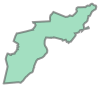

In [53]:
gdf['geometry'][0]

Удалим все неактуальные значения

In [54]:
# у нас нет данных о доходах позднее 2022 года, поэтому 23 и 24 год не нужны.
gdf = gdf[~gdf['year_from'].isin([2023, 2024])]
gdf['territory_id'] = gdf['territory_id'].astype(int)
gdf_filtered = gdf[['territory_id', 'year_from', 'year_to', 'geometry']]

In [55]:
gdf_filtered.head()

territory_id  year_from  year_to  \
0           462       2018     9999   
1           461       2018     9999   
2           463       2018     9999   
3           464       2018     9999   
4           465       2018     9999   

                                            geometry  
0  MULTIPOLYGON (((45.90308 43.32412, 45.90501 43...  
1  MULTIPOLYGON (((45.67362 43.20324, 45.67349 43...  
2  MULTIPOLYGON (((45.18361 42.84240, 45.18339 42...  
3  MULTIPOLYGON (((45.95342 42.67815, 45.95197 42...  
4  MULTIPOLYGON (((45.47566 43.25142, 45.47502 43...

Присоединим файл с геопространственными данными

In [89]:

# Функция для расширения каждой строки по годам в указанном диапазоне
def expand_row(row):
    years = list(range(row['year_from'], row['year_to'] + 1))
    expanded_rows = pd.DataFrame({
        'territory_id': row['territory_id'],
        'Year': years,
        'geometry': row['geometry']
    })
    return expanded_rows

# Расширяем t_dic_filtered по годам и включаем все столбцы
expanded_dic = pd.concat([expand_row(row) for _, row in gdf_filtered.iterrows()], ignore_index=True)

# Объединение данных с учетом года
result_df = merged_df.merge(expanded_dic, left_on=['territory_id', 'Год'], right_on=['territory_id', 'Year'], how='left')




KeyboardInterrupt



In [57]:
result_df.head(20)

Регион  Номер региона Административный тип         Название  \
0   Алтайский край              1      Городской округ       г. Барнаул   
1   Алтайский край              1      Городской округ        г. Алейск   
2   Алтайский край              1      Городской округ    г. Белокуриха   
3   Алтайский край              1      Городской округ         г. Бийск   
4   Алтайский край              1      Городской округ       г. Заринск   
5   Алтайский край              1      Городской округ   г. Новоалтайск   
6   Алтайский край              1      Городской округ      г. Рубцовск   
7   Алтайский край              1      Городской округ     г. Славгород   
8   Алтайский край              1      Городской округ        г. Яровое   
9   Алтайский край              1  Муниципальный район         Алейский   
10  Алтайский край              1  Муниципальный район        Алтайский   
11  Алтайский край              1  Муниципальный район         Баевский   
12  Алтайский край              1  Муниципальный район          Бийский   
13  Алтайский край              1  Муниципальный район   Благовещенский   
14  Алтайский край              1  Муниципальный район       Бурлинский   
15  Алтайский край              1  Муниципальный район  Быстроистокский   
16  Алтайский край              1  Муниципальный район     Волчихинский   
17  Алтайский край              1  Муниципальный район      Егорьевский   
18  Алтайский край              1  Муниципальный район       Ельцовский   
19  Алтайский край              1  Муниципальный район     Завьяловекий   

    Код ОКТМО   Год  Доходы физлиц и ИП, т.р.  Соц. выплаты, т.р.  \
0     1701000  2018              1.433911e+08        4.892531e+07   
1     1703000  2018              2.350672e+06        1.958745e+06   
2     1704000  2018              3.358961e+06        1.104414e+06   
3     1705000  2018              2.864631e+07        1.667412e+07   
4     1706000  2018              6.135012e+06        3.363121e+06   
5     1713000  2018              1.261486e+07        4.642149e+06   
6     1716000  2018              1.231713e+07        1.001992e+07   
7     1719000  2018              6.497577e+06        2.834544e+06   
8     1730000  2018              1.253232e+06        1.537898e+06   
9     1601000  2018              1.140899e+06        9.309836e+05   
10    1602000  2018              1.549958e+06        1.925262e+06   
11    1603000  2018              7.110789e+05        7.744209e+05   
12    1604000  2018              1.807290e+06        2.468633e+06   
13    1605000  2018              4.883102e+06        2.146845e+06   
14    1606000  2018              5.070495e+05        8.064870e+05   
15    1607000  2018              3.673809e+05        6.971548e+05   
16    1608000  2018              1.935862e+06        1.261706e+06   
17    1609000  2018              8.870728e+05        9.826224e+05   
18    1610000  2018              3.369207e+05        4.495889e+05   
19    1611000  2018              1.333430e+06        1.371981e+06   

    Общие выплаты и доходы, т.р.  Выплаты и доходы на 1 жителя, р.      oktmo  \
0                   1.923164e+08                     276095.782098  1701000.0   
1                   4.309417e+06                     148039.045492  1703000.0   
2                   4.463375e+06                     294223.782173  1704000.0   
3                   4.532043e+07                     214821.344435  1705000.0   
4                   9.498133e+06                     204590.916080  1706000.0   
5                   1.725701e+07                     234457.463560  1713000.0   
6                   2.233705e+07                     155832.663992  1716000.0   
7                   9.332121e+06                     234799.868788  1719000.0   
8                   2.791130e+06                     154445.004914  1730000.0   
9                   2.071883e+06                     145548.482400  1601000.0   
10                  3.475220e+06                     134318.390822  1602000.0   
11            

In [58]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11531 entries, 0 to 11530
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Регион                            11531 non-null  object 
 1   Номер региона                     11531 non-null  int32  
 2   Административный тип              11531 non-null  object 
 3   Название                          11531 non-null  object 
 4   Код ОКТМО                         11531 non-null  int64  
 5   Год                               11531 non-null  int64  
 6   Доходы физлиц и ИП, т.р.          11531 non-null  float64
 7   Соц. выплаты, т.р.                11531 non-null  float64
 8   Общие выплаты и доходы, т.р.      11531 non-null  float64
 9   Выплаты и доходы на 1 жителя, р.  11531 non-null  float64
 10  oktmo                             11116 non-null  float64
 11  Year_x                            11116 non-null  float64
 12  muni

# С помощью версионного справочника построить ряды об объеме социальных выплат на территориях муниципальных образований в 2018-2023 годах с учетом изменений их типов, названий, кодов и территориального состава:
- если менялся тип, название и код, но территориальный состав оставался постоянным, то муниципальному образованию должен быть присвоен актуальный действующий код ОКТМО и построен непрерывный ряд значений показателя для соответствующей территории;
- если изменился территориальный состав, то ряд может прерываться.

In [59]:
territory_ids_2018 = result_df[(result_df['Номер региона'] == 1) & (result_df['Год'] == 2018)]['territory_id'].unique()
territory_ids_2019 = result_df[(result_df['Номер региона'] == 1) & (result_df['Год'] == 2019)]['territory_id'].unique()

territory_ids_2018, territory_ids_2019


(array([504., 505., 506., 507., 508., 509., 510., 511., 512., 514., 515.,
        516., 517., 518., 519., 520., 521., 522., 523., 524., 525., 526.,
        527., 528., 529., 530., 531., 532., 533., 534., 535., 536., 537.,
        538., 539., 540., 541., 542., 543., 544., 545., 546., 547., 548.,
        549., 550., 551., 552., 553., 554., 555., 556., 557., 558., 559.,
        560., 561., 562., 563., 564., 565., 566., 567., 568., 569., 570.,
        571., 572.]),
 array([504., 505., 506., 507., 508., 509., 510., 511., 512., 514., 515.,
        516., 517., 518., 519., 520., 521., 522., 523., 524., 525., 526.,
        527., 528., 529., 530., 531., 532., 533., 534., 535., 536., 537.,
        538., 539., 540., 541., 542., 543., 544., 545., 546., 547., 548.,
        549., 550., 551., 552., 553., 554., 555., 556., 557., 558., 559.,
        560., 561., 562., 563., 564., 565., 566., 567., 568., 569., 570.,
        571., 572.]))

В этих прмиерах territory_id одной и той же администартивной единицы не меняется в зависимости от года. Теперь надо отметить, у каких регионов менялись территориальные границы.

Отсортируем данные по territory_id и Год, чтобы последовательность записей была по каждому региону и каждому году.

Сравним значение в geometry для каждой административной единицы с предыдущим годом.

Если границы geometry не изменились по сравнению с прошлым годом, ставим 0 в новой колонке changes. Если границы изменились, то запишем год изменения.

In [60]:
# Сортируем по territory_id и Год
result_df = result_df.sort_values(by=["territory_id", "Год"]).reset_index(drop=True)

# Создаем новую колонку changes, заполняем ее 0
result_df['changes'] = 0

# Проходим по всем строкам, кроме первой
for i in range(1, len(result_df)):
    # Проверяем, если предыдущая строка имеет тот же territory_id
    if result_df.loc[i, 'territory_id'] == result_df.loc[i - 1, 'territory_id']:
        # Сравниваем geometry с предыдущим годом
        if result_df.loc[i, 'geometry'] != result_df.loc[i - 1, 'geometry']:
            # Если границы изменились, записываем год изменения
            result_df.loc[i, 'changes'] = result_df.loc[i, 'Год']

# Просмотр итогового результата
result_df[['territory_id', 'Год', 'geometry', 'changes']].head(5)


territory_id   Год                                           geometry  \
0           1.0  2018  MULTIPOLYGON (((40.1305942 44.6775085, 40.1292...   
1           1.0  2019  MULTIPOLYGON (((40.1305942 44.6775085, 40.1292...   
2           1.0  2020  MULTIPOLYGON (((40.1305942 44.6775085, 40.1292...   
3           1.0  2021  MULTIPOLYGON (((40.1305942 44.6775085, 40.1292...   
4           1.0  2022  MULTIPOLYGON (((40.1305942 44.6775085, 40.1292...   

   changes  
0        0  
1        0  
2        0  
3        0  
4        0

In [61]:
#посмотрим, у какого процентра административных единиц поменялись границы
result_df['changes'].value_counts(normalize=True)

changes
0    1.0
Name: proportion, dtype: float64

Получается, что границы вообще не менялись. Данные могут быть не верны, если границы меняются вместе с territory_id или октмо. Надо это проверить. Для начала надо взять слово, которое скорее всего не будет меняться вместе с административным типом. Это название, написанное с большой буквы в колонке municipal_district_name. В новую колонку first_word_capitalized добавим все первые слова с большой буквы из municipal_district_name. В пределах одного региона в один год такое вряд ли повторится.

In [62]:
result_df['first_word_capitalized'] = (
    result_df['municipal_district_name']
    .str.extract(r'\b([А-ЯA-Z][a-яa-z]*-?[А-ЯA-Z]?[a-яa-z]*)')[0]
)

добавим проверку на изменения в связке значений "Номер региона", 'first_word_capitalized', "Код ОКТМО" и 'territory_id'. Если при переходе на следующий год меняется "Код ОКТМО" или 'territory_id', но остаются прежними "Номер региона" и 'first_word_capitalized', будем ставить в changes_octmo_id значение 1, иначе 0. Сразу посмотрим, что меняется - Код ОКТМО или territory_id.

Добавлено условие, что наличие или появление пропуска в territory_id при сохранении октмо не является признаком измнения границ, поэтому в changes_octmo_id будет ставиться 0.

In [63]:
# Сортируем и добавляем колонку changes_octmo_id
result_df = result_df.sort_values(by=["Номер региона", 'Название', "Год"]).reset_index(drop=True)
result_df['changes_octmo_id'] = 0

# Заполняем changes_octmo_id на основе условий
for i in range(1, len(result_df)):
    if (result_df.loc[i, 'Номер региона'] == result_df.loc[i - 1, 'Номер региона'] and 
        result_df.loc[i, 'Название'] == result_df.loc[i - 1, 'Название']):
        
        # Проверяем изменения в 'Код ОКТМО'
        oktmo_changed = result_df.loc[i, 'Код ОКТМО'] != result_df.loc[i - 1, 'Код ОКТМО']
        
        # Получаем текущие и предыдущие значения 'territory_id'
        territory_id_current = result_df.loc[i, 'territory_id']
        territory_id_previous = result_df.loc[i - 1, 'territory_id']
        
        # Проверяем, что 'territory_id' изменился, и оба значения не являются пропусками
        territory_changed = (
            pd.notna(territory_id_current) and 
            pd.notna(territory_id_previous) and 
            territory_id_current != territory_id_previous
        )
        
        # Проверяем, что 'Код ОКТМО' изменился, исключая случаи, когда:
        # 1. Текущее значение 'territory_id' — пропуск.
        # 2. Предыдущее значение 'territory_id' — пропуск, а текущее заполнено.
        if oktmo_changed and not (
            pd.isna(territory_id_current) or
            (pd.isna(territory_id_previous) and pd.notna(territory_id_current))
        ):
            result_df.loc[i, 'changes_octmo_id'] = 1
        elif territory_changed:
            result_df.loc[i, 'changes_octmo_id'] = 1

# Выбираем строки, где changes_octmo_id == 1, вместе с предшествующими строками
rows_with_changes = result_df[result_df['changes_octmo_id'] == 1].index
result_with_previous = pd.concat([result_df.loc[i-1:i] for i in rows_with_changes])

result_with_previous[['Номер региона', 'Название', 'Код ОКТМО', 'territory_id', 'Год', 'changes_octmo_id']]


Номер региона                 Название  Код ОКТМО  territory_id   Год  \
58                 1              Залесовский    1612000         525.0  2021   
59                 1              Залесовский    1512000         525.0  2022   
557                3                  г. Сочи    3726000         628.0  2021   
558                3                  г. Сочи    3726000        2812.0  2021   
697                4                Пировский    4645000         713.0  2020   
698                4                Пировский    4545000         713.0  2021   
1104               7               Предгорный    7548000         837.0  2022   
1105               7               Предгорный    7548000        2881.0  2022   
1157               7  город-курорт Кисловодск    7715000         816.0  2022   
1158               7  город-курорт Кисловодск    7715000        2876.0  2022   
1265              10              Белогорский   10608000         871.0  2020   
1266              10              Белогорский   10508000         871.0  2021   
1275              10                Бурейский   10615000         873.0  2020   
1276              10                Бурейский   10515000         873.0  2021   
1280              10              Завитинский   10621000         874.0  2020   
1281              10              Завитинский   10521000         874.0  2021   
1290              10               Ивановский   10628000         876.0  2020   
1291              10               Ивановский   10528000         876.0  2021   
1320              10               Ромненский   10640000         882.0  2020   
1321              10               Ромненский   10540000         882.0  2021   
1350              10               Тындинский   10654000         888.0  2020   
1351              10               Тындинский   10554000         888.0  2021   
1847              15            г. Новозыбков   15720000         955.0  2020   
1848              15            г. Новозыбков   15720000        2650.0  2020   
2500              22            Балахнинский    22605000        1539.0  2020   
2501              22            Балахнинский    22505000        1539.0  2021   
2505              22             Богородский    22607000        1540.0  2020   
2506              22             Богородский    22507000        1540.0  2021   
2520              22            Бутурлинский    22612000        1543.0  2020   
2521              22            Бутурлинский    22512000        1543.0  2021   
2525              22                 Вадский    22614000        1544.0  2020   
2526              22                 Вадский    22514000        1544.0  2021   
2555              22             Воротынский    22621000        1550.0  2020   
2556              22             Воротынский    22719000        1550.0  2021   
2579              22              Дивеевский    22632000        1555.0  2020   
2580              22              Дивеевский    22532000        1555.0  2021   
2589              22            Ковернинский    22634000        1557.0  2020   
2590              22            Ковернинский    22534000        1557.0  2021   
2605              22               Кстовский    22637000        1560.0  2021   
2606              22               Кстовский    22537000        1560.0  2022   
2614              22              Лысковский    22640000        1562.0  2020   
2615              22              Лысковский    22540000        1562.0  2021   
2619              22              Павловский    22642000        1563.0  2020   
2620              22              Павловский    22542000        1563.0  2021   
2629              22            Починковский    22646000        1565.0  2020   
2630              22            Починковский    22546000        1565.0  2021   
2659              22             Тоншаевский    22653000        1571.0  2020   
2660              22             Тоншаевский    22553000        1571.0  2021   
2664              22                Уренский    22654000        1572.0  2020   
2665   

In [64]:
result_df['changes_octmo_id'].value_counts(normalize=True)

changes_octmo_id
0    0.984563
1    0.015437
Name: proportion, dtype: float64

У 1,5% административных единиц менялся либо код октмо либо id. Некоторым административным единицам присвоились двойные id. В один и тот же год у одной административной единицы при сохранении октмо может быть разный ID.

In [65]:
result_with_previous.head(10)

Регион  Номер региона Административный тип  \
58         Алтайский край              1  Муниципальный район   
59         Алтайский край              1  Муниципальный округ   
557    Краснодарский край              3      Городской округ   
558    Краснодарский край              3      Городской округ   
697     Красноярский край              4  Муниципальный район   
698     Красноярский край              4  Муниципальный округ   
1104  Ставропольский край              7  Муниципальный округ   
1105  Ставропольский край              7  Муниципальный округ   
1157  Ставропольский край              7      Городской округ   
1158  Ставропольский край              7      Городской округ   

                     Название  Код ОКТМО   Год  Доходы физлиц и ИП, т.р.  \
58                Залесовский    1612000  2021              9.995957e+05   
59                Залесовский    1512000  2022              1.097283e+06   
557                   г. Сочи    3726000  2021              2.244965e+08   
558                   г. Сочи    3726000  2021              2.244965e+08   
697                 Пировский    4645000  2020              9.697718e+05   
698                 Пировский    4545000  2021              9.462812e+05   
1104               Предгорный    7548000  2022              2.084951e+07   
1105               Предгорный    7548000  2022              2.084951e+07   
1157  город-курорт Кисловодск    7715000  2022              2.404570e+07   
1158  город-курорт Кисловодск    7715000  2022              2.404570e+07   

      Соц. выплаты, т.р.  Общие выплаты и доходы, т.р.  \
58          1.247133e+06                  2.246728e+06   
59          1.457671e+06                  2.554955e+06   
557         4.496097e+07                  2.694575e+08   
558         4.496097e+07                  2.694575e+08   
697         6.540351e+05                  1.623807e+06   
698         7.257105e+05                  1.671992e+06   
1104        6.240156e+06                  2.708967e+07   
1105        6.240156e+06                  2.708967e+07   
1157        9.841473e+06                  3.388717e+07   
1158        9.841473e+06                  3.388717e+07   

      Выплаты и доходы на 1 жителя, р.      oktmo  Year_x  \
58                       170840.866883  1612000.0  2021.0   
59                       220749.495701  1512000.0  2022.0   
557                      519312.939117  3726000.0  2021.0   
558                      519312.939117  3726000.0  2021.0   
697                      243998.024149  4645000.0  2020.0   
698                      255969.339224  4545000.0  2021.0   
1104                     243131.119633  7548000.0  2022.0   
1105                     243131.119633  7548000.0  2022.0   
1157                     252380.832799  7715000.0  2022.0   
1158                     252380.832799  7715000.0  2022.0   

                      municipal_district_name  territory_id  \
58            Залесовский муниципальный район         525.0   
59            Залесовский муниципальный округ         525.0   
557         городской округ город-курорт Сочи         628.0   
558         городской округ город-курорт Сочи        2812.0   
697             Пировский муниципальный район         713.0   
698             Пировский муниципальный округ         713.0   
1104           Предгорный муниципальный округ         837.0   
1105           Предгорный муниципальный округ        2881.0   
1157  городской округ город-курорт Кисловодск         816.0   
1158  городской округ город-курорт Кисловодск        2876.0   

              region_name  region_code  Year_y  \
58         Алтайский край         22.0  2021.0   
59         Алтайский край         22.0  2022.0   
557    Краснодарский край         23.0  2021.0   
558    Краснодарский край         23.0  2021.0   
697     Красноярский край         24.0  2020.0   
698     Красноярский край         24.0  2021.0   
1104  Ставропольский край         26.0  2022.0   
1105  Ставропольский край         26.0  2022.0   
1157  Ставр

In [66]:
result_with_previous.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 58 to 11280
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Регион                            356 non-null    object 
 1   Номер региона                     356 non-null    int32  
 2   Административный тип              356 non-null    object 
 3   Название                          356 non-null    object 
 4   Код ОКТМО                         356 non-null    int64  
 5   Год                               356 non-null    int64  
 6   Доходы физлиц и ИП, т.р.          356 non-null    float64
 7   Соц. выплаты, т.р.                356 non-null    float64
 8   Общие выплаты и доходы, т.р.      356 non-null    float64
 9   Выплаты и доходы на 1 жителя, р.  356 non-null    float64
 10  oktmo                             356 non-null    float64
 11  Year_x                            356 non-null    float64
 12  municipal_

In [67]:
# Сортируем и добавляем колонку geometry_changes
result_with_previous = result_with_previous.sort_values(by=["Номер региона", "Название", "Год"]).reset_index(drop=True)
result_with_previous['geometry_changes'] = 0

# Проходим по каждой строке, чтобы сравнить пары с изменениями
for i in range(1, len(result_with_previous)):
    # Проверяем, что текущая строка и предыдущая — одна и та же административная единица
    if (result_with_previous.loc[i, 'Номер региона'] == result_with_previous.loc[i - 1, 'Номер региона'] and 
        result_with_previous.loc[i, 'Название'] == result_with_previous.loc[i - 1, 'Название']):
        
        # Если обнаружен переход от 0 к 1 в changes_octmo_id
        if result_with_previous.loc[i - 1, 'changes_octmo_id'] == 0 and result_with_previous.loc[i, 'changes_octmo_id'] == 1:
            # Сравниваем значения в 'geometry'
            geometry_changed = result_with_previous.loc[i, 'geometry'] != result_with_previous.loc[i - 1, 'geometry']
            
            # Если границы изменились, ставим год изменения, если нет — ставим 0
            if geometry_changed:
                result_with_previous.loc[i - 1:i, 'geometry_changes'] = result_with_previous.loc[i, 'Год']
            else:
                result_with_previous.loc[i - 1:i, 'geometry_changes'] = 0

# Отобразим результат с новыми столбцами
result_with_previous[['Номер региона', 'Название', 'Код ОКТМО', 'territory_id', 'Год', 'geometry', 'changes_octmo_id', 'geometry_changes']]


Номер региона                 Название  Код ОКТМО  territory_id   Год  \
0                1              Залесовский    1612000         525.0  2021   
1                1              Залесовский    1512000         525.0  2022   
2                3                  г. Сочи    3726000         628.0  2021   
3                3                  г. Сочи    3726000        2812.0  2021   
4                4                Пировский    4645000         713.0  2020   
5                4                Пировский    4545000         713.0  2021   
6                7               Предгорный    7548000         837.0  2022   
7                7               Предгорный    7548000        2881.0  2022   
8                7  город-курорт Кисловодск    7715000         816.0  2022   
9                7  город-курорт Кисловодск    7715000        2876.0  2022   
10              10              Белогорский   10608000         871.0  2020   
11              10              Белогорский   10508000         871.0  2021   
12              10                Бурейский   10615000         873.0  2020   
13              10                Бурейский   10515000         873.0  2021   
14              10              Завитинский   10621000         874.0  2020   
15              10              Завитинский   10521000         874.0  2021   
16              10               Ивановский   10628000         876.0  2020   
17              10               Ивановский   10528000         876.0  2021   
18              10               Ромненский   10640000         882.0  2020   
19              10               Ромненский   10540000         882.0  2021   
20              10               Тындинский   10654000         888.0  2020   
21              10               Тындинский   10554000         888.0  2021   
22              15            г. Новозыбков   15720000         955.0  2020   
23              15            г. Новозыбков   15720000        2650.0  2020   
24              22            Балахнинский    22605000        1539.0  2020   
25              22            Балахнинский    22505000        1539.0  2021   
26              22             Богородский    22607000        1540.0  2020   
27              22             Богородский    22507000        1540.0  2021   
28              22            Бутурлинский    22612000        1543.0  2020   
29              22            Бутурлинский    22512000        1543.0  2021   
30              22                 Вадский    22614000        1544.0  2020   
31              22                 Вадский    22514000        1544.0  2021   
32              22             Воротынский    22621000        1550.0  2020   
33              22             Воротынский    22719000        1550.0  2021   
34              22              Дивеевский    22632000        1555.0  2020   
35              22              Дивеевский    22532000        1555.0  2021   
36              22            Ковернинский    22634000        1557.0  2020   
37              22            Ковернинский    22534000        1557.0  2021   
38              22               Кстовский    22637000        1560.0  2021   
39              22               Кстовский    22537000        1560.0  2022   
40              22              Лысковский    22640000        1562.0  2020   
41              22              Лысковский    22540000        1562.0  2021   
42              22              Павловский    22642000        1563.0  2020   
43              22              Павловский    22542000        1563.0  2021   
44              22            Починковский    22646000        1565.0  2020   
45              22            Починковский    22546000        1565.0  2021   
46              22             Тоншаевский    22653000        1571.0  2020   
47              22             Тоншаевский    22553000        1571.0  2021   
48              22                Уренский    22654000        1572.0  2020   
49              22                Уренский    22554000        1572.0  2021   
50              27         

теперь мы знаем, в какой год, в какой административной единице менялись границы. Добавим эти информацию к result_df

In [68]:
# Создаем новый столбец 'geometry_changes' в result_df и заполняем его нулями
result_df['geometry_changes'] = 0

# Фильтруем строки в result_with_previous, где geometry_changes ненулевые
nonzero_geometry_changes = result_with_previous[result_with_previous['geometry_changes'] != 0]

# Итерируем по отфильтрованным строкам и заполняем значения в result_df
for idx, row in nonzero_geometry_changes.iterrows():
    # Определяем уникальные критерии для нахождения строки в result_df
    region_number = row['Номер региона']
    name = row['Название']
    year = row['Год']
    
    # Находим соответствующую строку в result_df и обновляем geometry_changes
    result_df.loc[
        (result_df['Номер региона'] == region_number) & 
        (result_df['Название'] == name) & 
        (result_df['Год'] == year), 
        'geometry_changes'
    ] = row['geometry_changes']


In [69]:
result_df['geometry_changes'].value_counts(normalize=True)

geometry_changes
0       0.994190
2020    0.001908
2019    0.001648
2022    0.001388
2021    0.000694
2018    0.000173
Name: proportion, dtype: float64

Как видим, в 0,06% наблюдений границы действительно менялись. При этом измнение границ не обязательно связано с изменением кода октмо или territory_id.

In [70]:
result_df[result_df['geometry_changes'] == 2018]

Регион  Номер региона Административный тип      Название  \
7509  Свердловская область             65      Городской округ  Камышловский   
7510  Свердловская область             65  Муниципальный район  Камышловский   

      Код ОКТМО   Год  Доходы физлиц и ИП, т.р.  Соц. выплаты, т.р.  \
7509   65741000  2018                 4178749.9        1.873363e+06   
7510   65623000  2018                 2083033.5        1.986607e+06   

      Общие выплаты и доходы, т.р.  Выплаты и доходы на 1 жителя, р.  \
7509                  6.052113e+06                     229490.112815   
7510                  4.069640e+06                     140579.648822   

           oktmo  Year_x           municipal_district_name  territory_id  \
7509  65741000.0  2018.0      городской округ Камышловский        1987.0   
7510  65623000.0  2018.0  Камышловский муниципальный район        2040.0   

               region_name  region_code  Year_y  \
7509  Свердловская область         66.0  2018.0   
7510  Свердловская область         66.0  2018.0   

                                               geometry  changes  \
7509  MULTIPOLYGON (((62.6705675 56.8442957, 62.6776...        0   
7510  POLYGON ((62.9734348 56.838775, 62.9752862 56....        0   

     first_word_capitalized  changes_octmo_id  geometry_changes  
7509           Камышловский                 0              2018  
7510           Камышловский                 1              2018

Как видим, в Свердловской области в одной административной единице изменения произошли в первый же год наблюдений.

In [71]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11531 entries, 0 to 11530
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Регион                            11531 non-null  object 
 1   Номер региона                     11531 non-null  int32  
 2   Административный тип              11531 non-null  object 
 3   Название                          11531 non-null  object 
 4   Код ОКТМО                         11531 non-null  int64  
 5   Год                               11531 non-null  int64  
 6   Доходы физлиц и ИП, т.р.          11531 non-null  float64
 7   Соц. выплаты, т.р.                11531 non-null  float64
 8   Общие выплаты и доходы, т.р.      11531 non-null  float64
 9   Выплаты и доходы на 1 жителя, р.  11531 non-null  float64
 10  oktmo                             11116 non-null  float64
 11  Year_x                            11116 non-null  float64
 12  muni

In [72]:
mask = result_df.apply(lambda x: x.astype(str).str.contains('Сочи', na=False).any(), axis=1)

# Получаем строки, где есть слово 'Сочи'
sample = result_df[mask]

sample

Регион  Номер региона Административный тип Название  \
554  Краснодарский край              3      Городской округ  г. Сочи   
555  Краснодарский край              3      Городской округ  г. Сочи   
556  Краснодарский край              3      Городской округ  г. Сочи   
557  Краснодарский край              3      Городской округ  г. Сочи   
558  Краснодарский край              3      Городской округ  г. Сочи   
559  Краснодарский край              3      Городской округ  г. Сочи   

     Код ОКТМО   Год  Доходы физлиц и ИП, т.р.  Соц. выплаты, т.р.  \
554    3726000  2018              1.178738e+08        3.900770e+07   
555    3726000  2019              1.320901e+08        4.009764e+07   
556    3726000  2020              1.607026e+08        4.663924e+07   
557    3726000  2021              2.244965e+08        4.496097e+07   
558    3726000  2021              2.244965e+08        4.496097e+07   
559    3726000  2022              2.492839e+08        5.568999e+07   

     Общие выплаты и доходы, т.р.  Выплаты и доходы на 1 жителя, р.  \
554                  1.568815e+08                     304214.364031   
555                  1.721877e+08                     326603.601006   
556                  2.073418e+08                     390325.735465   
557                  2.694575e+08                     519312.939117   
558                  2.694575e+08                     519312.939117   
559                  3.049739e+08                     541850.292091   

         oktmo  Year_x            municipal_district_name  territory_id  \
554  3726000.0  2018.0  городской округ город-курорт Сочи         628.0   
555  3726000.0  2019.0  городской округ город-курорт Сочи         628.0   
556  3726000.0  2020.0  городской округ город-курорт Сочи         628.0   
557  3726000.0  2021.0  городской округ город-курорт Сочи         628.0   
558  3726000.0  2021.0  городской округ город-курорт Сочи        2812.0   
559  3726000.0  2022.0  городской округ город-курорт Сочи        2812.0   

            region_name  region_code  Year_y  \
554  Краснодарский край         23.0  2018.0   
555  Краснодарский край         23.0  2019.0   
556  Краснодарский край         23.0  2020.0   
557  Краснодарский край         23.0  2021.0   
558  Краснодарский край         23.0  2021.0   
559  Краснодарский край         23.0  2022.0   

                                              geometry  changes  \
554  POLYGON ((39.9381781 43.4059361, 39.9366876 43...        0   
555  POLYGON ((39.9381781 43.4059361, 39.9366876 43...        0   
556  POLYGON ((39.9381781 43.4059361, 39.9366876 43...        0   
557  POLYGON ((39.9381781 43.4059361, 39.9366876 43...        0   
558  MULTIPOLYGON (((39.8843581 43.4936145, 39.8841...        0   
559  MULTIPOLYGON (((39.8843581 43.4936145, 39.8841...        0   

    first_word_capitalized  changes_octmo_id  geometry_changes  
554                   Сочи                 0                 0  
555                   Сочи                 0                 0  
556                   Сочи                 0                 0  
557                   Сочи                 0              2021  
558                   Сочи                 1              2021  
559                   Сочи                 0                 0

Теперь всем административным единицам, у которых не менялись границы, присвоим новые уникальные коды, которые не будут зависеть от измнения ОКТМО. Уникальные коды присвоены и административным единицам, у которых границы менялись, но лишь для записей до измнения.

In [73]:
# Создаем копию result_df, чтобы избежать изменения оригинального датафрейма
result_df_copy = result_df.copy()

# Присваиваем начальный уникальный код для строк без изменений границ
result_df_copy['unique_code'] = (
    result_df_copy[result_df_copy['geometry_changes'] == 0]
    .groupby(['Номер региона', 'Название'])
    .ngroup() + 1
)

# Присваиваем NaN всем строкам с изменениями границ для дальнейшей обработки
result_df_copy.loc[result_df_copy['geometry_changes'] != 0, 'unique_code'] = np.nan

# Для каждой административной единицы проверяем год первого изменения границ и устанавливаем unique_code = 0 с этого года
for name, group in result_df_copy.groupby(['Номер региона', 'Название']):
    # Находим минимальный год с изменением границ
    change_year = group.loc[group['geometry_changes'] != 0, 'Год'].min()
    
    if pd.notna(change_year):
        # Присваиваем unique_code = 0 для всех годов с момента изменения
        result_df_copy.loc[(result_df_copy['Номер региона'] == name[0]) &
                           (result_df_copy['Название'] == name[1]) &
                           (result_df_copy['Год'] >= change_year), 'unique_code'] = 0

# Заменяем NaN значения на 0 в unique_code
result_df_copy['unique_code'] = result_df_copy['unique_code'].fillna(0).astype(int)

# Присваиваем обработанный unique_code в исходный DataFrame
result_df['unique_code'] = result_df_copy['unique_code']

# Отобразим результат для проверки
result_df[['Номер региона', 'Название', 'Год', 'Код ОКТМО', 'geometry_changes', 'changes_octmo_id', 'unique_code']].head(20)


Номер региона                                           Название   Год  \
0                  1                                           Алейский  2018   
1                  1                                           Алейский  2019   
2                  1                                           Алейский  2020   
3                  1                                           Алейский  2021   
4                  1                                           Алейский  2022   
5                  1                                          Алтайский  2018   
6                  1                                          Алтайский  2019   
7                  1                                          Алтайский  2020   
8                  1                                          Алтайский  2021   
9                  1                                          Алтайский  2022   
10                 1                                           Баевский  2018   
11                 1                                           Баевский  2019   
12                 1                                           Баевский  2020   
13                 1                                           Баевский  2021   
14                 1                                           Баевский  2022   
15                 1                                            Бийский  2018   
16                 1                                            Бийский  2019   
17                 1                                            Бийский  2020   
18                 1                                            Бийский  2021   
19                 1                                            Бийский  2022   
20                 1                                     Благовещенский  2018   
21                 1                                     Благовещенский  2019   
22                 1                                     Благовещенский  2020   
23                 1                                     Благовещенский  2021   
24                 1                                     Благовещенский  2022   
25                 1                                         Бурлинский  2018   
26                 1                                         Бурлинский  2019   
27                 1                                         Бурлинский  2020   
28                 1                                         Бурлинский  2021   
29                 1                                         Бурлинский  2022   
30                 1                                    Быстроистокский  2018   
31                 1                                    Быстроистокский  2019   
32                 1                                    Быстроистокский  2020   
33                 1                                    Быстроистокский  2021   
34                 1                                    Быстроистокский  2022   
35                 1                                       Волчихинский  2018   
36                 1                                       Волчихинский  2019   
37                 1                                       Волчихинский  2020   
38                 1                                       Волчихинский  2021   
39                 1                                       Волчихинский  2022   
40                 1                                        Егорьевский  2018   
41                 1                                        Егорьевский  2019   
42                 1                                        Егорьевский  2020   
43                 1                                        Егорьевский  2021   
44                 1                                        Егорьевский  2022   
45                 1                                         Ельцовский  2018   
46                 1                                         Ельцовский  2019   
47                 1                                         Ельцовский  2020   
48                 1                  

In [74]:
result_df.head()

Регион  Номер региона Административный тип  Название  Код ОКТМО  \
0  Алтайский край              1  Муниципальный район  Алейский    1601000   
1  Алтайский край              1  Муниципальный район  Алейский    1601000   
2  Алтайский край              1  Муниципальный район  Алейский    1601000   
3  Алтайский край              1  Муниципальный район  Алейский    1601000   
4  Алтайский край              1  Муниципальный район  Алейский    1601000   

    Год  Доходы физлиц и ИП, т.р.  Соц. выплаты, т.р.  \
0  2018              1.140899e+06        9.309836e+05   
1  2019              1.456674e+06        9.915130e+05   
2  2020              1.591329e+06        1.135975e+06   
3  2021              2.147498e+06        1.180669e+06   
4  2022              2.117073e+06        1.378294e+06   

   Общие выплаты и доходы, т.р.  Выплаты и доходы на 1 жителя, р.      oktmo  \
0                  2.071883e+06                     145548.482400  1601000.0   
1                  2.448187e+06                     176496.772057  1601000.0   
2                  2.727304e+06                     201962.660154  1601000.0   
3                  3.328167e+06                     254252.600283  1601000.0   
4                  3.495368e+06                     247810.538743  1601000.0   

   Year_x       municipal_district_name  territory_id     region_name  \
0  2018.0  Алейский муниципальный район         514.0  Алтайский край   
1  2019.0  Алейский муниципальный район         514.0  Алтайский край   
2  2020.0  Алейский муниципальный район         514.0  Алтайский край   
3  2021.0  Алейский муниципальный район         514.0  Алтайский край   
4  2022.0  Алейский муниципальный район         514.0  Алтайский край   

   region_code  Year_y                                           geometry  \
0         22.0  2018.0  POLYGON ((83.0692709 52.1664232, 83.0525928 52...   
1         22.0  2019.0  POLYGON ((83.0692709 52.1664232, 83.0525928 52...   
2         22.0  2020.0  POLYGON ((83.0692709 52.1664232, 83.0525928 52...   
3         22.0  2021.0  POLYGON ((83.0692709 52.1664232, 83.0525928 52...   
4         22.0  2022.0  POLYGON ((83.0692709 52.1664232, 83.0525928 52...   

   changes first_word_capitalized  changes_octmo_id  geometry_changes  \
0        0               Алейский                 0                 0   
1        0               Алейский                 0                 0   
2        0               Алейский                 0                 0   
3        0               Алейский                 0                 0   
4        0               Алейский                 0                 0   

   unique_code  
0            1  
1            1  
2            1  
3            1  
4            1

Посмотрим, как коды присвоились на примере Сочи.

In [75]:
mask = result_df.apply(lambda x: x.astype(str).str.contains('Сочи', na=False).any(), axis=1)
sample = result_df[mask]
sample

Регион  Номер региона Административный тип Название  \
554  Краснодарский край              3      Городской округ  г. Сочи   
555  Краснодарский край              3      Городской округ  г. Сочи   
556  Краснодарский край              3      Городской округ  г. Сочи   
557  Краснодарский край              3      Городской округ  г. Сочи   
558  Краснодарский край              3      Городской округ  г. Сочи   
559  Краснодарский край              3      Городской округ  г. Сочи   

     Код ОКТМО   Год  Доходы физлиц и ИП, т.р.  Соц. выплаты, т.р.  \
554    3726000  2018              1.178738e+08        3.900770e+07   
555    3726000  2019              1.320901e+08        4.009764e+07   
556    3726000  2020              1.607026e+08        4.663924e+07   
557    3726000  2021              2.244965e+08        4.496097e+07   
558    3726000  2021              2.244965e+08        4.496097e+07   
559    3726000  2022              2.492839e+08        5.568999e+07   

     Общие выплаты и доходы, т.р.  Выплаты и доходы на 1 жителя, р.  \
554                  1.568815e+08                     304214.364031   
555                  1.721877e+08                     326603.601006   
556                  2.073418e+08                     390325.735465   
557                  2.694575e+08                     519312.939117   
558                  2.694575e+08                     519312.939117   
559                  3.049739e+08                     541850.292091   

         oktmo  Year_x            municipal_district_name  territory_id  \
554  3726000.0  2018.0  городской округ город-курорт Сочи         628.0   
555  3726000.0  2019.0  городской округ город-курорт Сочи         628.0   
556  3726000.0  2020.0  городской округ город-курорт Сочи         628.0   
557  3726000.0  2021.0  городской округ город-курорт Сочи         628.0   
558  3726000.0  2021.0  городской округ город-курорт Сочи        2812.0   
559  3726000.0  2022.0  городской округ город-курорт Сочи        2812.0   

            region_name  region_code  Year_y  \
554  Краснодарский край         23.0  2018.0   
555  Краснодарский край         23.0  2019.0   
556  Краснодарский край         23.0  2020.0   
557  Краснодарский край         23.0  2021.0   
558  Краснодарский край         23.0  2021.0   
559  Краснодарский край         23.0  2022.0   

                                              geometry  changes  \
554  POLYGON ((39.9381781 43.4059361, 39.9366876 43...        0   
555  POLYGON ((39.9381781 43.4059361, 39.9366876 43...        0   
556  POLYGON ((39.9381781 43.4059361, 39.9366876 43...        0   
557  POLYGON ((39.9381781 43.4059361, 39.9366876 43...        0   
558  MULTIPOLYGON (((39.8843581 43.4936145, 39.8841...        0   
559  MULTIPOLYGON (((39.8843581 43.4936145, 39.8841...        0   

    first_word_capitalized  changes_octmo_id  geometry_changes  unique_code  
554                   Сочи                 0                 0          114  
555                   Сочи                 0                 0          114  
556                   Сочи                 0                 0          114  
557                   Сочи                 0              2021            0  
558                   Сочи                 1              2021            0  
559                   Сочи                 0                 0            0

Все корректно. Сочи не присваивается unique_code после измнения границ.

Распределим регионы по федеральным округам

In [76]:
regions = [
    'Алтайский край', 'Краснодарский край', 'Красноярский край', 'Приморский край', 'Ставропольский край',
    'Хабаровский край', 'Амурская область', 'Архангельская область без НАО', 'Архангельская область с НАО',
    'Астраханская область', 'Белгородская область', 'Брянская область', 'Владимирская область',
    'Волгоградская область', 'Вологодская область', 'Воронежская область', 'Нижегородская область',
    'Ивановская область', 'Иркутская область', 'Республика Ингушетия', 'Калининградская область',
    'Тверская область', 'Калужская область', 'Камчатский край', 'Кемеровская область', 'Кировская область',
    'Костромская область', 'Республика Крым', 'Самарская область', 'Курганская область', 'Курская область',
    'г. Санкт-Петербург', 'Ленинградская область', 'Липецкая область', 'Магаданская область', 'Московская область',
    'Мурманская область', 'Новгородская область', 'Новосибирская область', 'Омская область', 'Оренбургская область',
    'Орловская  область', 'Пензенская область', 'Пермский край', 'Псковская область', 'Ростовская область',
    'Рязанская область', 'Саратовская область', 'Сахалинская область', 'Свердловская область', 'Смоленская область',
    'Тамбовская область', 'Томская область', 'Тульская область', 'Тюменская область без автономных округов',
    'Ханты-Мансийский автономный округ', 'Ямало-Ненецкий автономный округ', 'Ульяновская область',
    'Челябинская область', 'Забайкальский край', 'Чукотский автономный округ', 'Ярославская область',
    'Республика Адыгея', 'Республика Башкортостан', 'Республика Бурятия', 'Республика Дагестан',
    'Кабардино-Балкарская Республика', 'Республика Алтай', 'Республика Калмыкия', 'Республика Карелия',
    'Республика Коми', 'Республика Марий Эл', 'Республика Мордовия', 'РСО-Алания', 'Карачаево-Черкесская Республика',
    'Республика Татарстан', 'Республика Тыва', 'Удмуртская Республика', 'Республика Хакасия', 'Чеченская республика',
    'Чувашская Республика', 'Республика Саха (Якутия)', 'Еврейская автономная область'
]

# Словарь распределения по федеральным округам
federal_districts = {
    'Центральный федеральный округ': [
        'Белгородская область', 'Брянская область', 'Владимирская область', 'Воронежская область',
        'Ивановская область', 'Калужская область', 'Костромская область', 'Курская область',
        'Липецкая область', 'Московская область', 'Орловская  область', 'Рязанская область', 'Смоленская область',
        'Тамбовская область', 'Тверская область', 'Тульская область', 'Ярославская область'
    ],
    'Южный федеральный округ': [
        'Республика Адыгея', 'Республика Калмыкия', 'Республика Крым', 'Краснодарский край', 'Астраханская область',
        'Волгоградская область', 'Ростовская область'
    ],
    'Северо-Западный федеральный округ': [
        'Республика Карелия', 'Республика Коми', 'Архангельская область без НАО', 'Архангельская область с НАО',
        'Вологодская область', 'Калининградская область', 'Ленинградская область', 'Мурманская область',
        'Новгородская область', 'Псковская область', 'г. Санкт-Петербург'
    ],
    'Дальневосточный федеральный округ': [
        'Республика Саха (Якутия)', 'Камчатский край', 'Приморский край', 'Хабаровский край',
        'Амурская область', 'Магаданская область', 'Сахалинская область', 'Еврейская автономная область',
        'Чукотский автономный округ'
    ],
    'Сибирский федеральный округ': [
        'Республика Алтай', 'Республика Бурятия', 'Республика Тыва', 'Республика Хакасия', 'Алтайский край',
        'Забайкальский край', 'Красноярский край', 'Иркутская область', 'Кемеровская область', 'Новосибирская область',
        'Омская область', 'Томская область'
    ],
    'Уральский федеральный округ': [
        'Курганская область', 'Свердловская область', 'Тюменская область без автономных округов',
        'Челябинская область', 'Ханты-Мансийский автономный округ', 'Ямало-Ненецкий автономный округ'
    ],
    'Приволжский федеральный округ': [
        'Республика Башкортостан', 'Республика Марий Эл', 'Республика Мордовия', 'Республика Татарстан',
        'Удмуртская Республика', 'Чувашская Республика', 'Кировская область', 'Нижегородская область',
        'Оренбургская область', 'Пензенская область', 'Самарская область', 'Саратовская область', 'Ульяновская область',
        'Пермский край'
    ],
    'Северо-Кавказский федеральный округ': [
        'Республика Дагестан', 'Республика Ингушетия', 'Кабардино-Балкарская Республика',
        'Карачаево-Черкесская Республика', 'РСО-Алания', 'Чеченская республика', 'Ставропольский край'
    ]
}

# Функция для распределения регионов по округам
def assign_federal_district(region, districts):
    for district, regions_list in districts.items():
        if region in regions_list:
            return district
    return 'Неизвестный округ'

# Создаем DataFrame с регионами и их распределением по округам
result_df['Федеральный округ'] = result_df['Регион'].apply(lambda x: assign_federal_district(x, federal_districts))


In [77]:
result_df[result_df['Федеральный округ'].isnull()]

Empty DataFrame
Columns: [Регион, Номер региона, Административный тип, Название, Код ОКТМО, Год, Доходы физлиц и ИП, т.р., Соц. выплаты, т.р., Общие выплаты и доходы, т.р., Выплаты и доходы на 1 жителя, р., oktmo, Year_x, municipal_district_name, territory_id, region_name, region_code, Year_y, geometry, changes, first_word_capitalized, changes_octmo_id, geometry_changes, unique_code, Федеральный округ]
Index: []

Нет регионов, которым бы не присвоился федеральный округ

In [78]:
result_df['Год'] = result_df['Год'].astype(int)

In [79]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11531 entries, 0 to 11530
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Регион                            11531 non-null  object 
 1   Номер региона                     11531 non-null  int32  
 2   Административный тип              11531 non-null  object 
 3   Название                          11531 non-null  object 
 4   Код ОКТМО                         11531 non-null  int64  
 5   Год                               11531 non-null  int32  
 6   Доходы физлиц и ИП, т.р.          11531 non-null  float64
 7   Соц. выплаты, т.р.                11531 non-null  float64
 8   Общие выплаты и доходы, т.р.      11531 non-null  float64
 9   Выплаты и доходы на 1 жителя, р.  11531 non-null  float64
 10  oktmo                             11116 non-null  float64
 11  Year_x                            11116 non-null  float64
 12  muni

теперь построим временной ряд соцвыплат в административной единице, где менялся административный тип

Тип данных 'Год' в result_df: int32
Тип данных 'Год' в filtered_df: int32
Тип данных 'Год' в admin_unit_data: int32


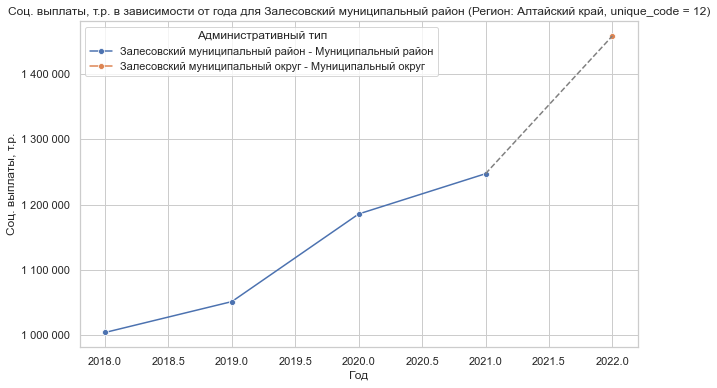

In [80]:
# Убедимся, что 'Год' сразу преобразован в int в исходных данных
result_df['Год'] = result_df['Год'].astype('int32')

# Фильтрация данных: выбираем строки, где geometry_changes == 0 и unique_code != 0
filtered_df = result_df[(result_df['geometry_changes'] == 0) & (result_df['unique_code'] != 0)]

# Ищем административные единицы, у которых изменялся "Административный тип"
changing_admin_type_units = (
    filtered_df.groupby('unique_code')
    .filter(lambda x: x['Административный тип'].nunique() > 1)
)

# Берем первый unique_code из таких единиц
unique_code_example = changing_admin_type_units['unique_code'].iloc[0]

# Фильтруем данные для этой административной единицы
admin_unit_data = changing_admin_type_units[changing_admin_type_units['unique_code'] == unique_code_example].copy()
admin_unit_data['Год'] = admin_unit_data['Год'].astype('int32')  # Убедимся, что 'Год' точно в int32

# Настраиваем стиль графика
sns.set(style="whitegrid")

# Создаем график
plt.figure(figsize=(10, 6))

# Группируем данные по "Административный тип" и строим линии последовательно
previous_type = None
previous_data = None

for admin_type in admin_unit_data['Административный тип'].unique():
    type_data = admin_unit_data[admin_unit_data['Административный тип'] == admin_type]
    
    # Строим линию для текущего административного типа
    sns.lineplot(
        data=type_data,
        x="Год",
        y="Соц. выплаты, т.р.",
        marker="o",
        label=f"{type_data['municipal_district_name'].iloc[0]} - {admin_type}"
    )
    
    # Соединяем последнюю точку предыдущего административного типа с первой точкой текущего типа
    if previous_data is not None:
        plt.plot(
            [previous_data['Год'].iloc[-1], type_data['Год'].iloc[0]],
            [previous_data['Соц. выплаты, т.р.'].iloc[-1], type_data['Соц. выплаты, т.р.'].iloc[0]],
            linestyle="--", color="gray"
        )
    
    # Обновляем предыдущий тип и данные
    previous_type = admin_type
    previous_data = type_data

# Настройки формата оси Y для полного отображения чисел
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

# Настройки графика
# Добавление названия региона в подпись графика
region_name = admin_unit_data['Регион'].iloc[0]
plt.title(f"Соц. выплаты, т.р. в зависимости от года для {admin_unit_data['municipal_district_name'].iloc[0]} (Регион: {region_name}, unique_code = {unique_code_example})")
plt.xlabel("Год")
plt.ylabel("Соц. выплаты, т.р.")
plt.legend(title="Административный тип")
plt.savefig("test-2_fig1.png", dpi=300, bbox_inches='tight')
plt.show()



Нарисуем временной ряд для соцвыплат в одной из административных единиц, где менялись границы.

C:\Users\User\AppData\Local\Temp\ipykernel_19008\2005872425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Год'] = filtered_df['Год'].astype(int)


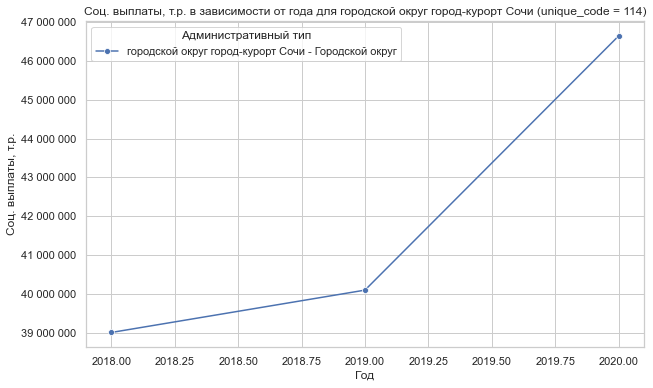

In [81]:
# Фильтруем строки, где unique_code != 0
filtered_df = result_df[result_df['unique_code'] != 0]
filtered_df['Год'] = filtered_df['Год'].astype(int)


# Находим unique_code, у которого хотя бы одна запись Год не равна 2022 и количество строк меньше 5
matching_unique_code = (
    filtered_df.groupby('unique_code')
    .filter(lambda x: (x['Год'] != 2022).any() and len(x) < 5)
    .unique_code.unique()
)

# Проверка наличия подходящих регионов
if len(matching_unique_code) == 0:
    print("Нет административных единиц, где год не равен 2022 и количество строк меньше 5.")
else:
    # Выбираем первый подходящий unique_code
    unique_code_example = matching_unique_code[3]

    # Остальной код для построения графика остается таким же...

    # Фильтруем данные для этой административной единицы
    admin_unit_data = filtered_df[filtered_df['unique_code'] == unique_code_example]

    # Настраиваем стиль графика
    sns.set(style="whitegrid")

    # Создаем график
    plt.figure(figsize=(10, 6))

    # Группируем данные по "Административный тип" и строим линии последовательно
    previous_data = None

    for admin_type in admin_unit_data['Административный тип'].unique():
        type_data = admin_unit_data[admin_unit_data['Административный тип'] == admin_type]
        
        # Строим линию для текущего административного типа
        sns.lineplot(
            data=type_data,
            x="Год",
            y="Соц. выплаты, т.р.",
            marker="o",
            label=f"{type_data['municipal_district_name'].iloc[0]} - {admin_type}"
        )
        
        # Соединяем последнюю точку предыдущего административного типа с первой точкой текущего типа
        if previous_data is not None:
            plt.plot(
                [previous_data['Год'].iloc[-1], type_data['Год'].iloc[0]],
                [previous_data['Соц. выплаты, т.р.'].iloc[-1], type_data['Соц. выплаты, т.р.'].iloc[0]],
                linestyle="--", color="gray"
            )
        
        # Обновляем предыдущий тип и данные
        previous_data = type_data

    # Настройки формата оси Y для полного отображения чисел
    plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

    # Настройки графика
    plt.title(f"Соц. выплаты, т.р. в зависимости от года для {admin_unit_data['municipal_district_name'].iloc[0]} (unique_code = {unique_code_example})")
    plt.xlabel("Год")
    plt.ylabel("Соц. выплаты, т.р.")
    plt.legend(title="Административный тип")
    plt.savefig("test-2_fig2.png", dpi=300, bbox_inches='tight')
    plt.show()


Теперь посмотрим на суммарные социальные выплаты в масштабах одного региона.

C:\Users\User\AppData\Local\Temp\ipykernel_19008\599104120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data['Год'] = region_data['Год'].astype(int)


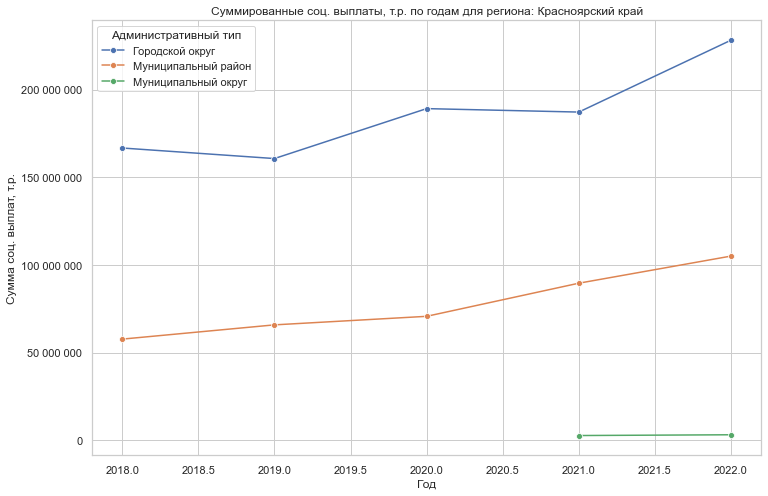

In [82]:
# Фильтруем данные для региона с Номер региона == 1 и ненулевыми unique_code
region_data = result_df[(result_df['Номер региона'] == 4) & (result_df['unique_code'] != 0)]
region_data['Год'] = region_data['Год'].astype(int)

# Группируем данные по 'Год' и 'Административный тип', суммируя 'Соц. выплаты, т.р.'
grouped_data = (
    region_data.groupby(['Год', 'Административный тип'])['Соц. выплаты, т.р.']
    .sum()
    .reset_index()
)

# Настраиваем стиль графика
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Строим линии для каждого уникального значения 'Административный тип' на одном графике
for admin_type in grouped_data['Административный тип'].unique():
    type_data = grouped_data[grouped_data['Административный тип'] == admin_type]
    sns.lineplot(
        data=type_data,
        x="Год",
        y="Соц. выплаты, т.р.",
        marker="o",
        label=admin_type
    )
# Настройки формата оси Y для полного отображения чисел
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))
    
# Получаем название региона для Номер региона == 1
region_name = region_data['Регион'].iloc[0]

# Настройки графика
plt.title(f"Суммированные соц. выплаты, т.р. по годам для региона: {region_name}")
plt.xlabel("Год")
plt.ylabel("Сумма соц. выплат, т.р.")
plt.legend(title="Административный тип")
plt.savefig("test-2_fig3.png", dpi=300, bbox_inches='tight')
plt.show()


Посмотрим на средние значения социальной помощи с доверительными интервалами в пределах федерального округа 

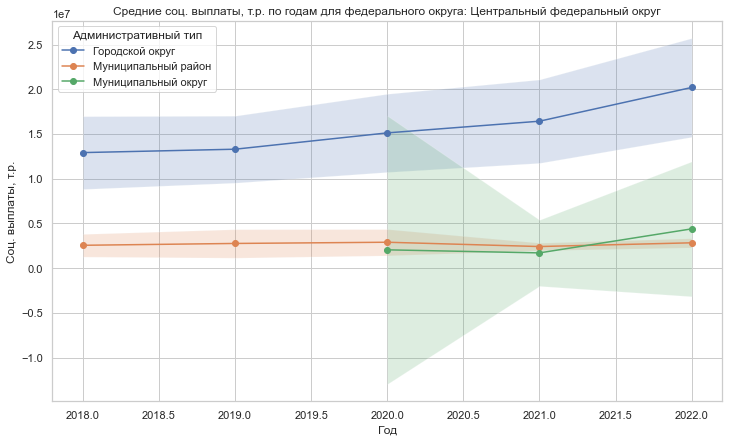

In [83]:
# Выбераем нужный федеральный округ
federal_district = "Центральный федеральный округ" 
district_data = result_df[result_df['Федеральный округ'] == federal_district]

# Группируем данные на уровне регионов, а затем по Год и Административный тип
grouped_data = (
    district_data
    .groupby(['Год', 'Административный тип', 'Регион'], as_index=False)
    .agg({'Соц. выплаты, т.р.': 'mean'})
)

# Считаем средние значения и доверительные интервалы на уровне федерального округа
confidence_intervals = (
    grouped_data
    .groupby(['Год', 'Административный тип'])
    .agg(
        mean_welfare=('Соц. выплаты, т.р.', 'mean'),
        lower=('Соц. выплаты, т.р.', lambda x: stats.t.interval(0.95, len(x)-1, loc=x.mean(), scale=stats.sem(x))[0]),
        upper=('Соц. выплаты, т.р.', lambda x: stats.t.interval(0.95, len(x)-1, loc=x.mean(), scale=stats.sem(x))[1])
    )
    .reset_index()
)

# Построение графика
plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")

# Визуализация среднего значения с доверительными интервалами
for admin_type in confidence_intervals['Административный тип'].unique():
    type_data = confidence_intervals[confidence_intervals['Административный тип'] == admin_type]
    
    plt.plot(
        type_data['Год'],
        type_data['mean_welfare'],
        marker='o',
        label=f"{admin_type}"
    )
    plt.fill_between(
        type_data['Год'],
        type_data['lower'],
        type_data['upper'],
        alpha=0.2
    )

# Настройки графика
plt.title(f"Средние соц. выплаты, т.р. по годам для федерального округа: {federal_district}")
plt.xlabel("Год")
plt.ylabel("Соц. выплаты, т.р.")
plt.legend(title="Административный тип")
plt.savefig("test-2_fig4.png", dpi=300, bbox_inches='tight')
plt.show()


# Проанализировать, как изменилась доля социальных выплат в структуре доходов населения муниципальных образований в 2023 году относительно 2018 года и предложить три типа визуализации. Предположить, чем могут объясняться выявленные паттерны.

In [84]:
#Добавим сведения о доли социальных выплат.
# Вычисление доли социальных выплат в общих доходах
result_df['Доля соц выплат'] = round((result_df['Соц. выплаты, т.р.'] / result_df['Общие выплаты и доходы, т.р.']) * 100, 2)
result_df['Год'] = result_df['Год'].astype(int)

# Фильтруем только 2018 и 2023 годы и ненулевые unique_code
filtered_df = result_df[(result_df['Год'].isin([2018, 2022])) & (result_df['unique_code'] != 0)]

# Группируем по федеральным округам и годам, вычисляя среднюю долю соц выплат
grouped_df = filtered_df.groupby(['Федеральный округ', 'Год'])['Доля соц выплат'].mean().reset_index()

In [85]:
result_df['Год'].head()

0    2018
1    2019
2    2020
3    2021
4    2022
Name: Год, dtype: int32

### Визуализация 1: Столбчатая диаграмма


In [86]:
# Словарь аббревиатур федеральных округов
abbreviations = {
    "Центральный федеральный округ": "ЦФО",
    "Южный федеральный округ": "ЮФО",
    "Северо-Западный федеральный округ": "СЗФО",
    "Дальневосточный федеральный округ": "ДФО",
    "Сибирский федеральный округ": "СФО",
    "Уральский федеральный округ": "УФО",
    "Приволжский федеральный округ": "ПФО",
    "Северо-Кавказский федеральный округ": "СКФО"
}

# Заменяем названия федеральных округов на аббревиатуры
grouped_df['Федеральный округ'] = grouped_df['Федеральный округ'].map(abbreviations)

# Построение столбчатой диаграммы с обновленными подписями
plt.figure(figsize=(12, 8))
sns.barplot(
    data=grouped_df, 
    x='Федеральный округ', 
    y='Доля соц выплат', 
    hue='Год', 
    palette="viridis"
)
plt.title("Изменение доли социальных выплат в доходах по федеральным округам (2018 и 2023 годы)")
plt.xlabel("Федеральный округ")
plt.ylabel("Доля социальных выплат")
plt.xticks(rotation=45)
plt.legend(title="Год")
plt.tight_layout()
plt.savefig("test-2_column.png", dpi=300, bbox_inches='tight')
plt.show()


### Визуализация 2: Линейный график изменений по годам с доверительными интервалами


In [87]:
# Фильтруем строки, где unique_code не равен 0
filtered_df = result_df[result_df['unique_code'] != 0]

# Группируем по федеральным округам и годам и вычисляем среднее и стандартное отклонение для "Доля соц выплат"
grouped_df = filtered_df.groupby(['Федеральный округ', 'Год'])['Доля соц выплат'].agg(['mean', 'std', 'count']).reset_index()
grouped_df['Год'].astype(int)
# Вычисляем доверительные интервалы
grouped_df['ci'] = 1.96 * grouped_df['std'] / grouped_df['count']**0.5  # 95% доверительный интервал

# Построение линейного графика с доверительными интервалами
plt.figure(figsize=(12, 8))

# Для каждого федерального округа строим линию и доверительные интервалы
for district in grouped_df['Федеральный округ'].unique():
    district_data = grouped_df[grouped_df['Федеральный округ'] == district]
    
    # Линия среднего значения
    plt.plot(district_data['Год'], district_data['mean'], marker='o', label=district)
    
    # Заливка для доверительного интервала
    plt.fill_between(
        district_data['Год'],
        district_data['mean'] - district_data['ci'],
        district_data['mean'] + district_data['ci'],
        alpha=0.2
    )

# Оформление графика
plt.title("Средняя доля социальных выплат по федеральным округам (с 95% доверительными интервалами)")
plt.xticks(ticks=grouped_df['Год'].unique(), labels=grouped_df['Год'].unique().astype(int))  # Устанавливаем целые числа на оси X
plt.ylabel("Средняя доля соц выплат в %")
plt.legend(title="Федеральный округ")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
#plt.savefig("test-2_linear_18_22_fed_dist.png", dpi=300, bbox_inches='tight')
plt.show()

Теперь посмотрим на три региона с самым большим приростом доли соцвыплат в доходах и с самым большим падением этой доли.

In [88]:

# Преобразуем столбец 'Год' в целочисленный формат
filtered_df['Год'] = filtered_df['Год'].astype(int)

# Группируем по регионам и годам, вычисляем среднее и стандартное отклонение для "Доля соц выплат"
grouped_df = filtered_df.groupby(['Регион', 'Год'])['Доля соц выплат'].agg(['mean', 'std', 'count']).reset_index()

# Вычисляем доверительные интервалы
grouped_df['ci'] = 1.96 * grouped_df['std'] / grouped_df['count']**0.5  # 95% доверительный интервал

# Рассчитываем изменения доли соцвыплат с 2018 по 2022 год
pivot_df = grouped_df.pivot(index='Регион', columns='Год', values='mean').dropna()
pivot_df['change'] = pivot_df[2022] - pivot_df[2018]

# Выбираем три региона с наибольшим ростом и три с наибольшим падением
top_rise_regions = pivot_df.nlargest(3, 'change').index
top_fall_regions = pivot_df.nsmallest(3, 'change').index
selected_regions = list(top_rise_regions) + list(top_fall_regions)

# Фильтруем данные только для выбранных регионов
selected_df = grouped_df[grouped_df['Регион'].isin(selected_regions)]

# Построение графика
plt.figure(figsize=(12, 8))

# Для каждого региона строим линию и доверительные интервалы
for region in selected_regions:
    region_data = selected_df[selected_df['Регион'] == region]
    
    # Линия среднего значения
    plt.plot(region_data['Год'], region_data['mean'], marker='o', label=region)
    
    # Заливка для доверительного интервала
    plt.fill_between(
        region_data['Год'],
        region_data['mean'] - region_data['ci'],
        region_data['mean'] + region_data['ci'],
        alpha=0.2
    )

# Оформление графика
plt.title("Изменение доли социальных выплат для регионов с наибольшим ростом и падением (2018-2022)")
plt.xlabel("Год")
plt.ylabel("Средняя доля соц выплат")
plt.xticks(ticks=[2018, 2019, 2020, 2021, 2022])  # Устанавливаем целые числа на оси X
plt.legend(title="Регион")
plt.savefig("test-2_linear_top6.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_19008\3505943126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Год'] = filtered_df['Год'].astype(int)
